# Сборный проект 2. Помощь аналитикам HR отдела.

## Краткое описание проекта

Необходимо помочь HR аналитикам компании "Работа с заботой" предугадать оттко сотрудников из компании. Для этого нам предоставлены данные форм, которые заполнили работники компании. При помощи этих данных необходимо определить уровень удовлетворенности персонала работающего в компании и попытаться предсказать увольнение сотрудников. Для этого необходимо воспользоваться алгоритмами машинного обучения.

## Техническое задание

1. ***Задача 1***
    - **Загрузка и знакомство с данными**
        - Загрузить данные в датафреймы
    - **Предобработка данных**
        - Изучить пропущенные значения
        - Найти полные и не полные дубликаты
        - Изучить распределение числовых значений, удалить аномалии
        - Привести название стволбцов к общему виду при необходимости
    - **Ислледовательский анализ данных**
        - Изучить распределение значений относительно целевого признака
        - Найти и описать зависимости между ними
     - **Корреляционный анализ**
         - Постристь матрицу корреляции и изучить данные на мультиколленеарность
     - **Подготовка данных**
         - Подготовить данные для работы с моделью
         - Разбить на выборки
         - Создать пайплайн которые будет делать все это автоматически
     - **Создание модели**
         - Перебрать в пайплайне как минимум две модели регрессии
         - Подобрать гиперпараметры
         - Создать метрику SMAPE и использовать ее для определения качества (сделать ее меньше или равной 15 на тесте)
         - Проанализировать работу модели
     - **Написать вывод по первой задаче**
2. ***Задача 2***
    - **Загрузка и знакомство с данными**
        - Загрузить данные в датафреймы
    - **Предобработка данных**
        - Изучить пропущенные значения
        - Найти полные и не полные дубликаты
        - Изучить распределение числовых значений, удалить аномалии
        - Привести название стволбцов к общему виду при необходимости
    - **Ислледовательский анализ данных**
        - Изучить распределение значений относительно целевого признака
        - Найти и описать зависимости между ними
     - **Корреляционный анализ**
         - Постристь матрицу корреляции и изучить данные на мультиколленеарность
     - **Подготовка данных**
         - Подготовить данные для работы с моделью
         - Разбить на выборки
         - Создать пайплайн которые будет делать все это автоматически
     - **Создание модели**
         - Перебрать в пайплайне как минимум три модели классификации
         - Подобрать гиперпараметры
         - Изучить метрику ROC-AUC (Сделать ее больше или равно 0.91 на тесте)
         - Проанализировать работу модели
     - **Написать вывод по второй задаче**
3. ***Общий вывод***
    - **Описать все проделанные действия**
    - **Выделить интересные особенности, если они есть**
    - **Написать о моделях**
    - **Написать рекомендации бизнесу на основе проведенного исследования**

## Все необходимые загрузки

In [1]:
!pip install ydata-profiling -q
!pip install shap -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Все необходимые импорты

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings


from ydata_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

import shap

import phik
from phik.report import plot_correlation_matrix

## Все используемые (самописные) функции

In [3]:
def countplot_creator(df: pd.DataFrame,
                      parametr_x: str,
                      parametr_y: str,
                      title: str,
                      xlabel: str,
                      ylabel: str) -> None:
    
    '''
    Функция принимает на вход датафрейм и параметры по которым будет строиться график. Так же на
    вход принимается значения которые будут подставлены в заголовок всего графика и его осей.
    
    Функция ничего не возвращает.
    '''
    
    sns.set()
    plt.figure(figsize=(15, 8))
    sns.countplot(data=df, x=parametr_x, hue=parametr_y)
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
def pie_creator(df: pd.DataFrame, parametr: str, title: str) -> None:
   
    '''
    Функция принимает на вход изучаемый датафрейм, параметр по которому будет проводиться
    рассчет и назавние которое будет у графика.
    
    Функция не возвращает ничего, а чертит график.
    '''
    
    sns.set()
    plt.figure(figsize=(7, 7))
    plt.pie(
        x=df[parametr].value_counts(),
        autopct='%1.1f%%',
        labels=df[parametr].value_counts().index,
    )
    plt.title(title,
              fontsize=14,
              fontweight='bold'
             )
    plt.show()

In [5]:
def smape_metrics(y_true, y_pred):
    n = len(y_true)
    nominator = 2*abs(y_true - y_pred)
    denominator = abs(y_true) + abs(y_pred)
    summa = (nominator/denominator).sum()
    return summa*(100/n)

In [6]:
def heatmap_corr_creator(df: pd.DataFrame, columns: list, title: str) -> None:
    '''
    Функция принимает на вход датафрейм и список столбцов(численного типа). Так же на
    вход принимается значения которое будут подставлен в заголовок всего графика.
    
    Функция ничего не возвращает.
    '''
    sns.set()
    plt.figure(figsize=(15,9))
    sns.heatmap(df[columns].corr(),
                annot=True,
                linewidth=.5,
                cmap='GnBu'
               )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.show()

In [7]:
def scatterplot_creator(df: pd.DataFrame,
                        parametr_x: str,
                        parametr_y: str,
                        title: str,
                        xlabel: str,
                        ylabel: str,
                        hue=None, 
                       ) -> None:
    
    '''
    Функция принимает на фход датафрейм, параметры по которым будет строиться график и 
    именя для оглавления всего графиков и имен осей. По заданным параметрам функция 
    нарисует диаграмму рассеяния и отобразит коэффициент корреляции.
    
    Функция ничего не возвращает.
    '''
    
    sns.set()
    plt.figure(figsize=(9,9)),
    sns.scatterplot(
        data=df,
        x=parametr_x,
        y=parametr_y,
        hue=hue
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(df[[parametr_y, parametr_x]].corr())

In [8]:
def boxplot_creator(df: pd.DataFrame,
                    parametr_x: str,
                    parametr_y: str,
                    title: str,
                    xlabel: str,
                    ylabel: str   
                   ) -> None:
    
    '''
    Функция принимает в качестве параметров датафрейм, параметр (название столбца)
    по которому будет строится ящик с усами, и строки с названием всего графика,
    оси Ox.
   
    На выходе функция не возвращает ничего. Функция строит ящик с усами по заданному параметру.
    '''
    
    sns.set()
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df,
                x=parametr_x,
                y=parametr_y,
                width=0.8,
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [9]:
def histogram_creator(df: pd.DataFrame,
                      parametr:str,
                      bins: int,
                      title: str,
                      xlabel: str,
                      ylabel: str,
                      hue=None
                     ) -> None:
   
    '''
    Функция принимает в качестве параметров датафрейм, параметр (название столбца)
    по которому будет строится гистограмма, число бинов и строки с названием всего графика,
    оси Ox и оси Oy, соответственно.
   
    На выходе функция не возвращает ничего. Функция строит гистограмму по заданному параметру.
    ''' 

    sns.set()
    plt.figure(figsize=(15, 8))
    sns.histplot(data=df,
                 x=parametr,
                 bins=bins,
                 color='#4f4d49',
                 edgecolor='black',
                 kde=True
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(df[parametr].describe())

# Задача 1

## Загрузка и знкомство с данными

In [10]:
try:
    train_df = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
except:
    train_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_df.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

На первый взгляд данные выглядят отлично. Столбцы записаны в **snake_case**, данные легко преобразовались в датафрейм.

In [11]:
try:
    test_features_df = pd.read_csv('datasets/test_features.csv')
except:
    test_features_df = pd.read_csv('/datasets/test_features.csv')
train_df.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

Эти данные тоже на превый взгляд выглядят хорошо. Все столбцы в **snake_case**, данные легко преобразовались в датафрейм.

In [12]:
try:
    test_target_df = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')
except:
    test_target_df = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_df.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

С этими данными на первый взгляд все тоже впорядке.

### Вывод по загрузке данных

Особых проблем с данными на этапе загрузки не замечано ни в одном датафрейме. На первый взгляд можно сказать, что данные достаточно высокого качества.

## Предобработка данных

### train_df

Сначала изучим пропуски.

In [13]:
train_df_shape_before_treatments = train_df.shape[0]
train_df_shape_before_treatments

4000

Во-первых предлагаю сделфть id индексом датафрейма.

In [14]:
train_df.set_index('id', inplace=True)
train_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

In [15]:
train_df.isna().sum()

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [16]:
train_df[train_df['dept'].isna()]

dept   level workload  employment_years last_year_promo  \
id                                                               
694746  NaN  junior   medium                 5              no   
814624  NaN  junior   medium                 3              no   
475114  NaN  junior     high                 4              no   
497243  NaN  junior   medium                 1              no   
168668  NaN  junior      low                 3              no   
641150  NaN  junior      low                 3              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
694746                   no                      4   21600   
814624                   no                      4   24000   
475114                   no                      4   31200   
497243                   no                      3   26400   
168668                   no                      4   18000   
641150                  yes                      4   12000   

        job_satisfaction_rate  
id                             
694746                   0.62  
814624                   0.88  
475114                   0.63  
497243                   0.28  
168668                   0.88  
641150                   0.54

In [17]:
train_df[train_df['level'].isna()]

dept level workload  employment_years last_year_promo  \
id                                                               
631073  sales   NaN   medium                 1              no   
416327  sales   NaN      low                 1              no   
135043  sales   NaN   medium                 1              no   
998838  sales   NaN   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
631073                   no                      4   27600   
416327                   no                      5   18000   
135043                   no                      3   26400   
998838                   no                      5   27600   

        job_satisfaction_rate  
id                             
631073                   0.66  
416327                   0.73  
135043                   0.30  
998838                   0.71

Пропусков не так много, удалять мы из не станем, потому что все эти пропуски обработаются в пайплайне при помоще SimpleImputer.

Теперь необходимо проверить данные на наличие полных дубликатов.

In [18]:
train_df.duplicated().sum()

245

Достаточно много, но это дубликаты и их не мало, они могут испортить работу модели в будущем.

In [19]:
train_df.drop_duplicates(inplace=True)
train_df.duplicated().sum()

0

Теперь в датафрейме нет явных дубликатов.

Отлично, теперь можно проверить, как распределены данные. Заодно проверим наличие неявных дубликатов и ошибок внутри столбцов.

In [20]:
profile_train_df = ProfileReport(train_df, title="Profiling report for train_df")
profile_train_df.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ошибок внутри столбцов(ошибок значений по типу '', '-' и т.д.) нет. Поэтому можно посмотреть как распределены все столбцы.

1. **dept**
    - Больше всего работников в отделе продаж
    - Меньше всего в отделе HR
2. **level**
    - Больше всего работников уровня middle
    - На втором месте junior
    - Меньше всего senior
3. **workload**
    - У большинства сотрудников средняя загруженность
    - На втором месте низкая загруженность
    - Меньше всего сотрудников с высокой загруженностью
4. **employment_years**
    - Больше содрудников с небольшим опытом работы в данной компании - это можно было предположить на моменте изучения столбца **level**
    - Больше всего сотрудником с одним годом работы - 22.6% от всех данных
    - Меньше всего сотрудников проработавших в компании 10 лет - 2.4% от всех данных
    - Распределение вглядит логично и сопоставимо с жизнью
5. **last_year_promo**
    - Большинство сотрудников не получили повышение за послдедний год - 96.8% от всех данных
    - Только 3% сотрудников получили повышение за последний год
6. **last_year_violations**
    - Большая часть сотрудников не нарушало трудового договора за последний год работы - 85.3% от всех данных
    - 14.7% сотрудников нарушили трудовой договор за последний год - не мало
7. **supervisor_evaluation**
    - Деятельность большинства работников руководитель оценивает на 4 - 38.6% от всех данных
    - На втором месте троешники - 31.7% от всех данных
    - Меньше всего работников которые работали на 1 по мнению руководителя - 5.3%, что тоже не так уж мало
8. **salary**
    - Зарплаты распределены нормально, но с сильным смещением впрво
    - Самая мальенькая зарплата составляет 12 т.р.
    - Самая высокая 98.4 т.р.
    - Средняя зарплата равна примерно 34.49 т.р.
    - Медианная 31.2 т.р - такая разница между средним и медианой обусловлена смещением в данных
    - У большей части работников зарплата ментьше 60 т.р.
9. **job_satisfaction_rate**
    - Данные распределены нормально, с небольшим смещением вправо, что хорошо для компании
    - Минимальный уровень удовлетворенности сотрудников равен 0.03
    - Максимальный 1
    - Средний уровень удовлетворенности равен 0.53
    - Медианный 0.55
    - У большинства пользователей уровень удовлетворенности работой в компании ментше 0.8
     

In [21]:
1 - train_df.shape[0] / train_df_shape_before_treatments

0.06125000000000003

В процессе предобработки было потеряно 6.1% данных. Это ни как не повлияет на результат работы, потому что в основном это дубликаты.

### test_features_df

In [22]:
test_features_df_shape_before_treatmens = test_features_df.shape[0]
test_features_df_shape_before_treatmens

2000

Предлагаю тут тоже сделать id индексом датафрейма

In [23]:
test_features_df.set_index('id', inplace=True)
test_features_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800

Для начала изучим пропуски в данных

In [24]:
test_features_df.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [25]:
test_features_df[test_features_df['dept'].isna()]

dept   level workload  employment_years last_year_promo  \
id                                                               
609865  NaN  junior   medium                 1              no   
832342  NaN  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
609865                   no                      1   20400  
832342                   no                      4   28800

In [26]:
test_features_df[test_features_df['level'].isna()]

dept level workload  employment_years last_year_promo  \
id                                                               
471990  sales   NaN      low                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
471990                   no                      3   12000

Опять же данные потеряны в тех столбцах в которых из ничем не заменит, поэтому просто удалим строки в которых есть пропуски.

In [27]:
test_features_df.dropna(subset=['dept', 'level'], inplace=True)
test_features_df.isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Теперь проверим данные на наличие полных дубликатов.

In [28]:
test_features_df.duplicated().sum()

557

В данных очень много явных дубликатов, но так как это тестовый датафрейм их нет смысла удалять. Они ни на что не повлияют и мы не можем контролировать поток тестовых данных в реальных задачах.

In [29]:
profile_test_features_df = ProfileReport(test_features_df, title="Profiling report for test_features_df")
profile_test_features_df.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Сразу бросается в глаза, что в столбце workload и dept есть значение '', удалю его позднне, сначала взнлянем на респределение данных по столбцам. Это значение не помешает этому.

1. **dept**
    - Больше всего работников в отделе продаж
    - Меньше всего в отделе HR
2. **level**
    - Больше всего работников уровня junior
    - На втором месте middle
    - Меньше всего senior
3. **workload**
    - У большинства сотрудников средняя загруженность
    - На втором месте низкая загруженность
    - Меньше всего сотрудников с высокой загруженностью
4. **employment_years**
    - Больше содрудников с небольшим опытом работы в данной компании - это можно было предположить на моменте изучения столбца **level**
    - Больше всего сотрудником с одним годом работы - 26% от всех данных
    - Меньше всего сотрудников проработавших в компании 10 лет - 1.8% от всех данных
    - Распределение вглядит логично и сопоставимо с жизнью
5. **last_year_promo**
    - Большинство сотрудников не получили повышение за послдедний год - 96.8% от всех данных
    - Только 3.2% сотрудников получили повышение за последний год
6. **last_year_violations**
    - Большая часть сотрудников не нарушало трудового договора за последний год работы - 86.9% от всех данных
    - 13.1% сотрудников нарушили трудовой договор за последний год - не мало
7. **supervisor_evaluationsupervisor_evaluation**
    - Деятельность большинства работников руководитель оценивает на 4 - 42.9% от всех данных
    - На втором месте троешники - 28.7% от всех данных
    - Меньше всего работников которые работали на 1 по мнению руководителя - 4.4%
8. **salarysalary**
    - Зарплаты распределены нормально, но с сильным смещением впрво
    - Самая мальенькая зарплата составляет 12 т.р.
    - Самая высокая 96 т.р.
    - Средняя зарплата равна примерно 34 т.р.
    - Медианная 30 т.р - такая разница между средним и медианой обусловлена смещением в данных
    - У большей части работников зарплата ментьше 60 т.р.

Строки со значениями "", " " удалять не будем удалять по той же логике, что выше - это тестовый датафрейм мы не можем контролировать и изменать его. Плюс все эти значения обработаются в пайплайне.

In [30]:
display(test_features_df['workload'].unique())
test_features_df['dept'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', ' '],
      dtype=object)

Датафрейм готов к использованию.

In [31]:
1 - test_features_df.shape[0] / test_features_df_shape_before_treatmens

0.0014999999999999458

На этапе предобработки потеряно меньше одного процента данных. Это никак не повлияет на результат исследования.

### test_target_df

Тут тоже предлогаю сделать id индексом датафрейма.

In [32]:
test_target_df.set_index('id', inplace=True)
test_target_df.head()

job_satisfaction_rate
id                           
130604                   0.74
825977                   0.75
418490                   0.60
555320                   0.72
826430                   0.08

Проверим данные на наличие пропусков и явных дубликатов.

In [33]:
test_target_df.isna().sum()

job_satisfaction_rate    0
dtype: int64

Пропусков в этом датафрейме нет.

In [34]:
test_target_df.duplicated().sum()

1902

Дубликатов много, но их много по той причине что значение цлевого столбца могут повторяться а разница id не учитывается. Поэтому удалять мы не будем, к тому же это целевое значение тествого датафрейма, по идее мы не можем регулировать его.

In [35]:
test_target_df['job_satisfaction_rate'].unique()

array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

Таких значений тоже не обнаружено. Изучим распределение столбца **job_satisfaction_rate**.

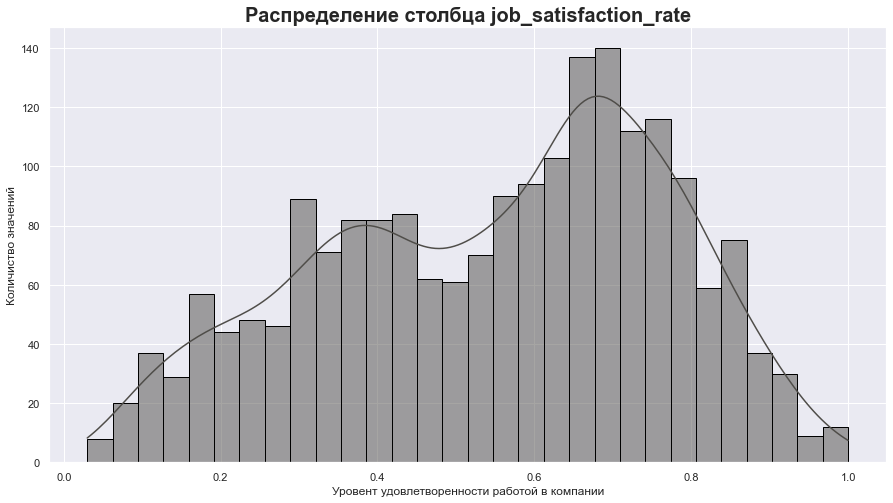

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [36]:
histogram_creator(test_target_df,
                  'job_satisfaction_rate',
                  30,
                  'Распределение столбца job_satisfaction_rate',
                  'Уровент удовлетворенности работой в компании',
                  'Количиство значений'
                 )

- Значения распределены нормально с небольшим смещением впрво, что хорошо для компании
- Минимальное значение удовлетворенности равно 0.03
- Максимальное 1
- Среднее значение удовлетворенности равно примерно 0.55
- Медианное 0.58
- Уровень удовлетворенности работой большинства сотрудников меньше чем 0.8

### Вывод по предобработке данных
1. **train_df**
    - Были удалены пропуски
    - На этапе предобработки потреяно примерно 6% данных
    - Данные достаточно высокого качества не смотря на то, что это опросник по форме
2. **test_features_df**
    - Были удалены пропуски
    - Были удалены занчения '' и ' '
    - На этапе предобработки данных потеряно менее одного процента от всех данных
    - Данные достаточно высого качества
3. **test_target_df**
    - Пропусков и дубликатов в столбце нет
    - Данные высокого качества 
    - Не было удалено ни одной строки
    
Более подробноое описание распределение столбцов можно постомтреть в конце изучения каждого из датафреймов.

## Исследоватьельский анализ данных

### train_df

Рассмотрим как признаки распределены относитьельно целвого, постараемся найти интересные закономерности.

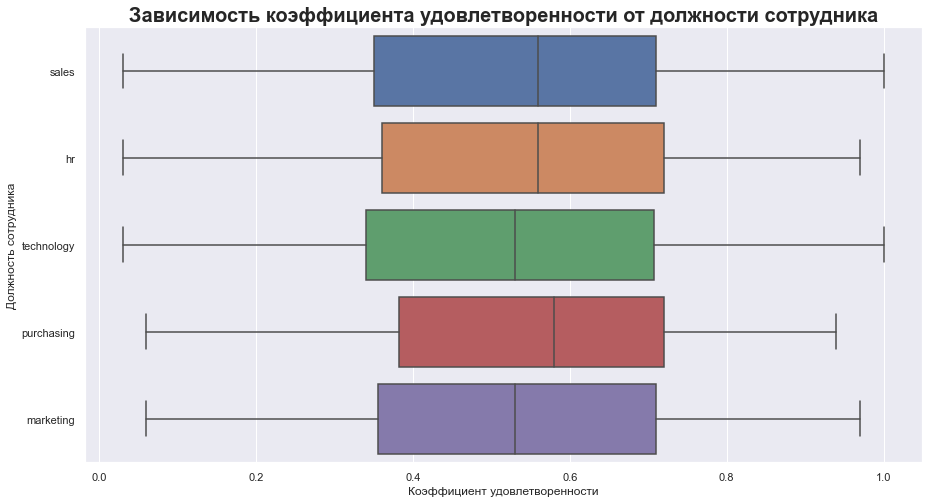

In [37]:
boxplot_creator(train_df,
                'job_satisfaction_rate',
                'dept',
                'Зависимость коэффициента удовлетворенности от должности сотрудника',
                'Коэффициент удовлетворенности',
                'Должность сотрудника'
               )

В этом столбце нет ничего особо интересного, все сотрудники имеют примерно одинаковый разброс коэффициентов удовлетворенности работой. Боксплоты даже не показали выбросов ни в одной из категории сотрудников. Можно только сказать, что самый низкий разброс у сотрудинков из отдела закупок, у них же самое высокое медианное значение. Самое маленькое медианное значение у иаркетологов.

Так же не обязаетльно, но интересно посмотреть как распределены зарплаты по категориям сотрудников.

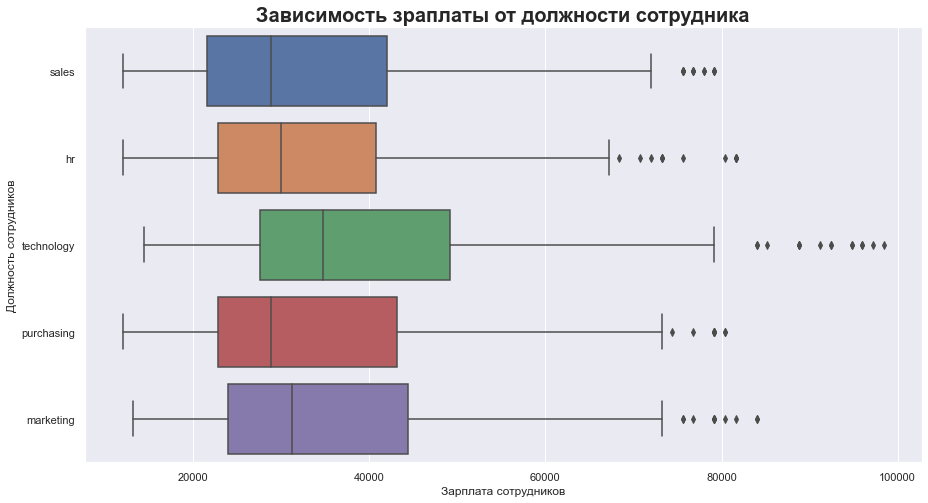

In [38]:
boxplot_creator(train_df,
                'salary',
                'dept',
                'Зависимость зраплаты от должности сотрудника',
                'Зарплата сотрудников',
                'Должность сотрудников'
               )

Самые высокие зарплаты у сотрудников из отдела технологий, у них самый большой "выброс" и самое большое медианное значение с размахом усов графика. Самые нихкие в отделе продаж и закупок. В принципе ничего сверхъестественного в таком распределении нет.

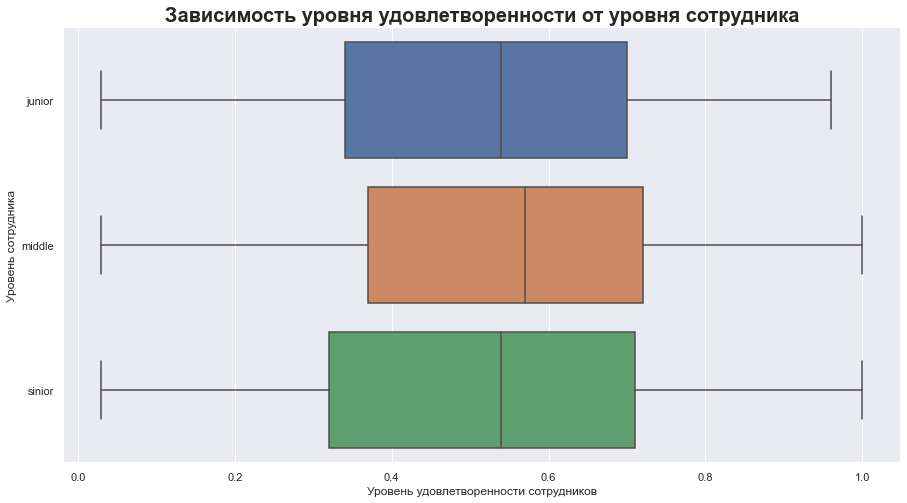

In [39]:
boxplot_creator(train_df,
                'job_satisfaction_rate',
                'level',
                'Зависимость уровня удовлетворенности от уровня сотрудника',
                'Уровень удовлетворенности сотрудников',
                'Уровень сотрудника',
               )

Больше всего из сатрудников своей работой довольны мидлы, меньше всего сеньйоры и чуть больше удовлетворены джуны. Тут тоже никаких необычных закономерностей нет, все данные примерно одинаково распределены относительно целевого признака.

Так же из интереса предлагаю посмотреть, как распределены зарплаты относительно уровня сотрудника

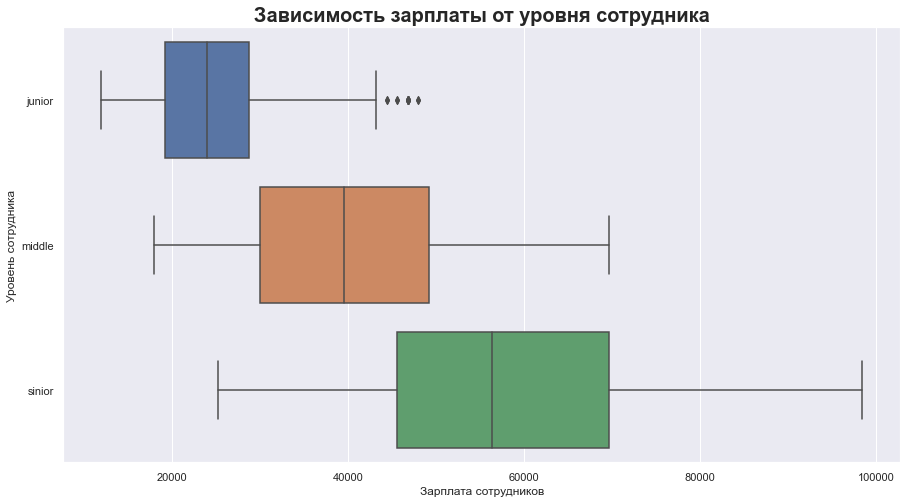

In [40]:
boxplot_creator(train_df,
                'salary',
                'level',
                'Зависимость зарплаты от уровня сотрудника',
                'Зарплата сотрудников',
                'Уровень сотрудника',
               )

Как и стоило предположить самые мальнькие зарплаты у джунов, да в них есть выбросы но они еле дотягиваюся до третьего квартиля зарплат у мидлов. Самые высокие зарплаты у сеньеров.

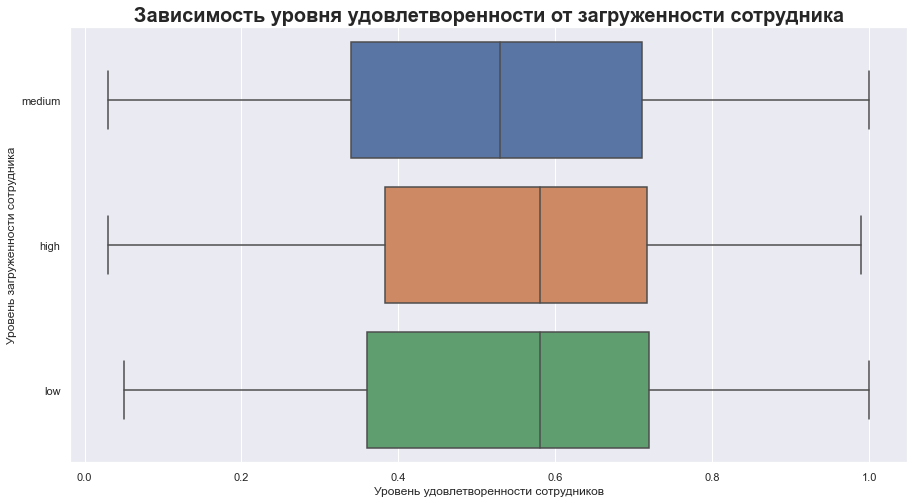

In [41]:
boxplot_creator(train_df,
                'job_satisfaction_rate',
                'workload',
                'Зависимость уровня удовлетворенности от загруженности сотрудника',
                'Уровень удовлетворенности сотрудников',
                'Уровень загруженности сотрудника'
               )

По этому графику тоже сказать нечего, все значения примерно одинаково распределены относительно целевого признака, т.е. уровень удовлетворенности сотрудникво почти никак не зависит от его загруженности.

Опять же в качестве научного интереса предлагаю рассмотреть распределение зарплат относитльно этого признака.

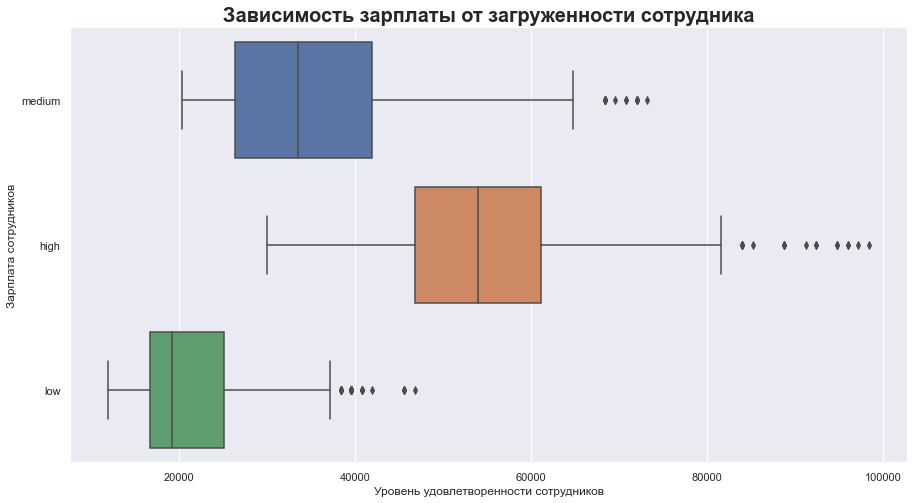

In [42]:
boxplot_creator(train_df,
                'salary',
                'workload',
                'Зависимость зарплаты от загруженности сотрудника',
                'Уровень удовлетворенности сотрудников',
                'Зарплата сотрудников'
               )

Тут тоже все логично. Кто больше работает, тому больше платят.

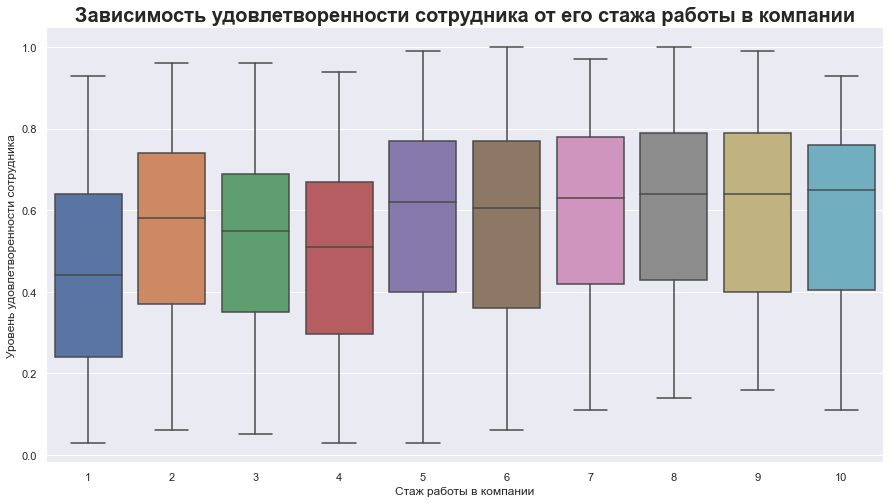

In [43]:
boxplot_creator(train_df,
                'employment_years',
                'job_satisfaction_rate',
                'Зависимость удовлетворенности сотрудника от его стажа работы в компании',
                'Стаж работы в компании',
                'Уровень удовлетворенности сотрудника'
               )

Тут прослеживается совсем небольшая зависимость - чем дольше сотрудник работает в компании, тем выше его уровень удовлетворенностю работы, но это совсем незначительная зависимость.

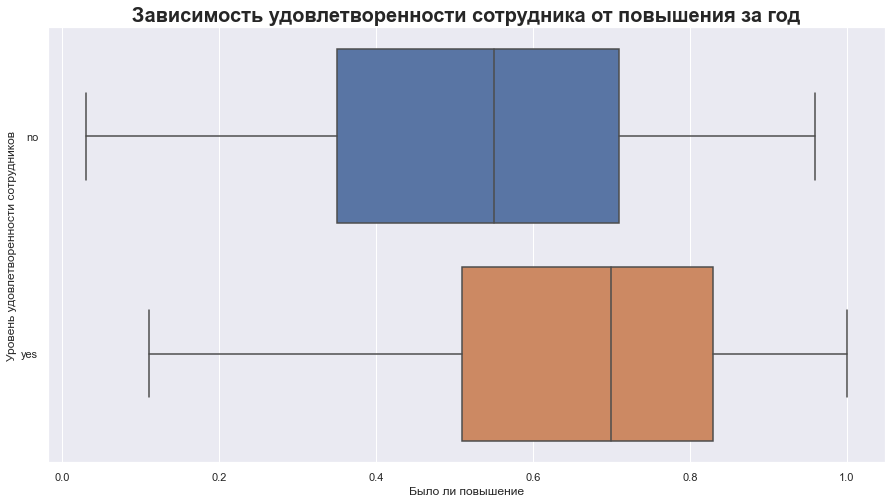

In [44]:
boxplot_creator(train_df,
                'job_satisfaction_rate',
                'last_year_promo',
                'Зависимость удовлетворенности сотрудника от повышения за год',
                'Было ли повышение',
                'Уровень удовлетворенности сотрудников'
               )

Тут все просто, сотрудники получившие повышение за прошедший год более довольны своей работой. Медианное значение уровня удовлетворенности таких сотрудников примерно равно 0.7, у сотрудников без повышения оно равно где-то 0.55.

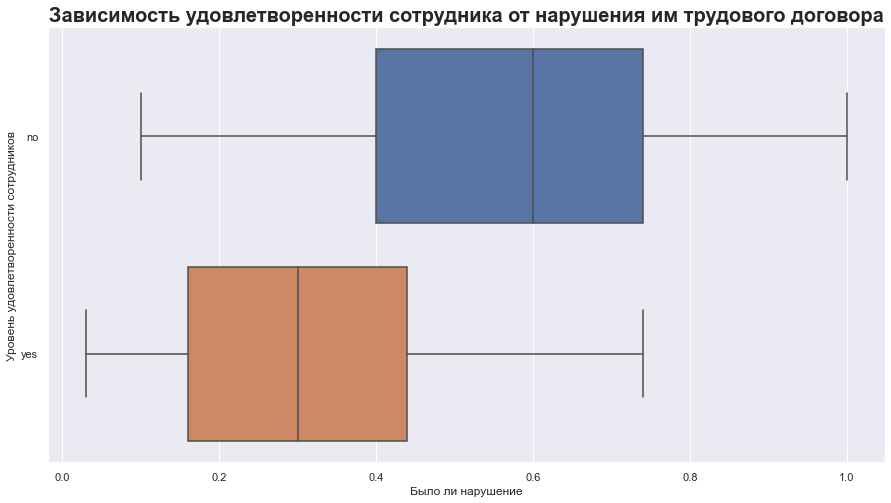

In [45]:
boxplot_creator(train_df,
                'job_satisfaction_rate',
                'last_year_violations',
                'Зависимость удовлетворенности сотрудника от нарушения им трудового договора',
                'Было ли нарушение',
                'Уровень удовлетворенности сотрудников'
               )

Пока что самая яркая из характеристик, сотрудники не нарушающие трудовой договор в большинстве своем более довольны работой.

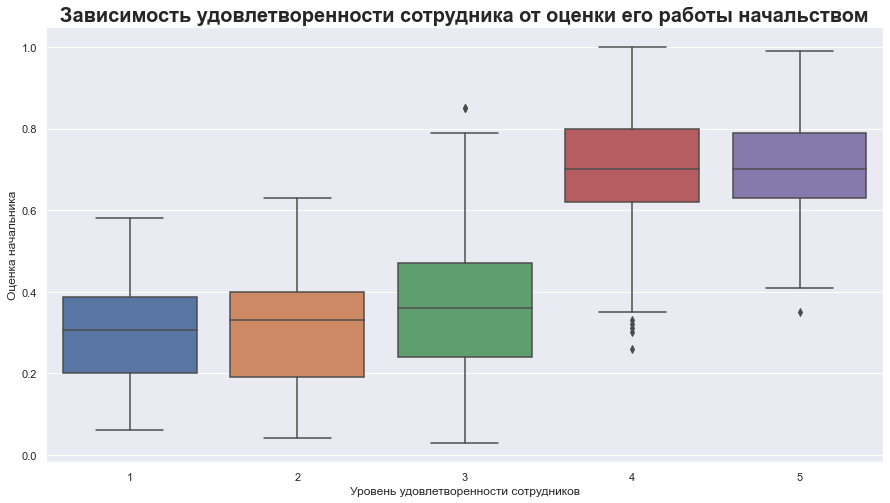

In [46]:
boxplot_creator(train_df,
                'supervisor_evaluation',
                'job_satisfaction_rate',
                'Зависимость удовлетворенности сотрудника от оценки его работы начальством',
                'Уровень удовлетворенности сотрудников',
                'Оценка начальника'
               )

Тут тоже все предельно ясно, чем выше начальник оценивает работу сотрудника тем более сотрудник удовлетворено своей работой. Из замечаний у сотрудников с оценкой 4, есть небольшой хвост из выбросов снизу, но он нам не помешает, возможно это люди которые должны были работать на 5 для повышения, но у них не вышло. Так же заметен резкий скачок между трешниками и "ударниками", начиная с 4 уровень удовлетворенности работой резко возрастает.

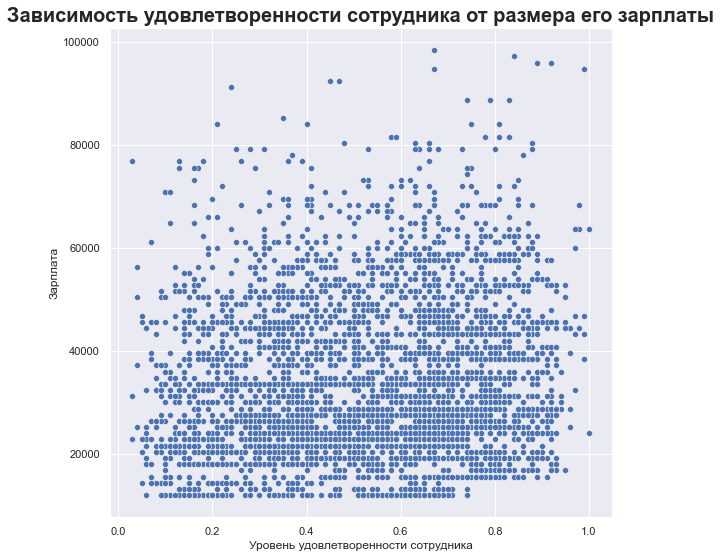

salary  job_satisfaction_rate
salary                 1.000000               0.113787
job_satisfaction_rate  0.113787               1.000000

In [47]:
scatterplot_creator(train_df,
                    'job_satisfaction_rate',
                    'salary',
                    'Зависимость удовлетворенности сотрудника от размера его зарплаты',
                    'Уровень удовлетворенности сотрудника',
                    'Зарплата'
                   )

На удивление особой закономерности нет, об этом говорит как визуализация, так и коэффициент корреляции. Можно сказать, что есть небольшая, но она почти не выделяется и вряд-ли как-то исказит работу модели.

### Объединение датафреймов

Для удобства исследования объединим датафреймы **test_features_df** и **test_target_df**.

In [48]:
test_df = test_features_df.merge(test_target_df, on='id')
test_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
485046                   no                      5   28800   
686555                   no                      4   30000   
467458                   no                      4   19200   
418655                   no                      4   19200   
789145                   no                      5   40800   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75

### test_df
Рассмотрим как в тестовой выборке прзнаки распределены относительно целевого.

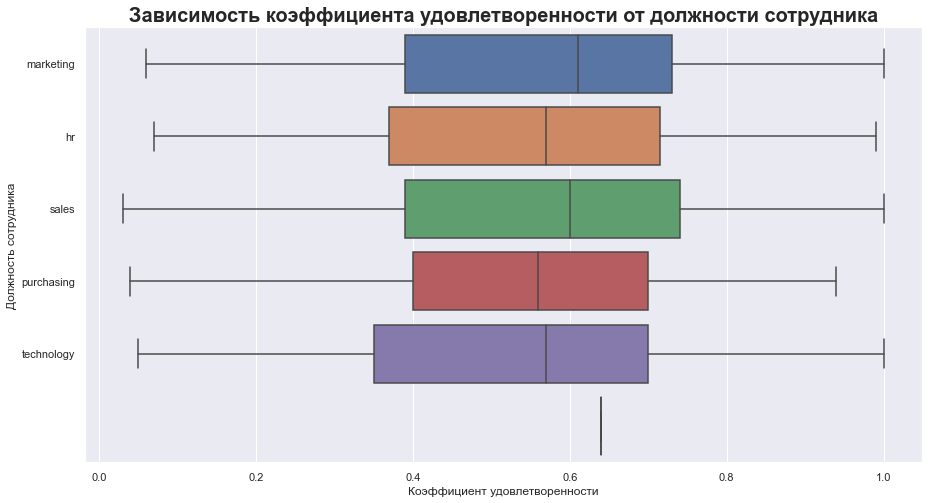

In [49]:
boxplot_creator(test_df,
                'job_satisfaction_rate',
                'dept',
                'Зависимость коэффициента удовлетворенности от должности сотрудника',
                'Коэффициент удовлетворенности',
                'Должность сотрудника'
               )

Тоже никакой особой зависимоти не наблюдается, данные похожи на тренировочную выборку. Только общий уровень удовлетворенности стал чуть выше. Проверим не произошло ли изменеий в данных с зарплатами.

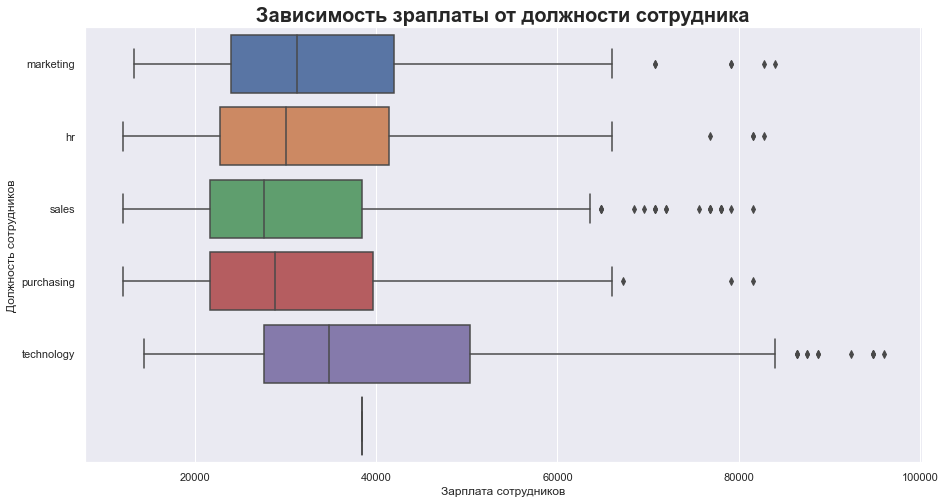

In [50]:
boxplot_creator(test_df,
                'salary',
                'dept',
                'Зависимость зраплаты от должности сотрудника',
                'Зарплата сотрудников',
                'Должность сотрудников'
               )

Примерно то же самое, что и в данных из тренировочной выборки. 

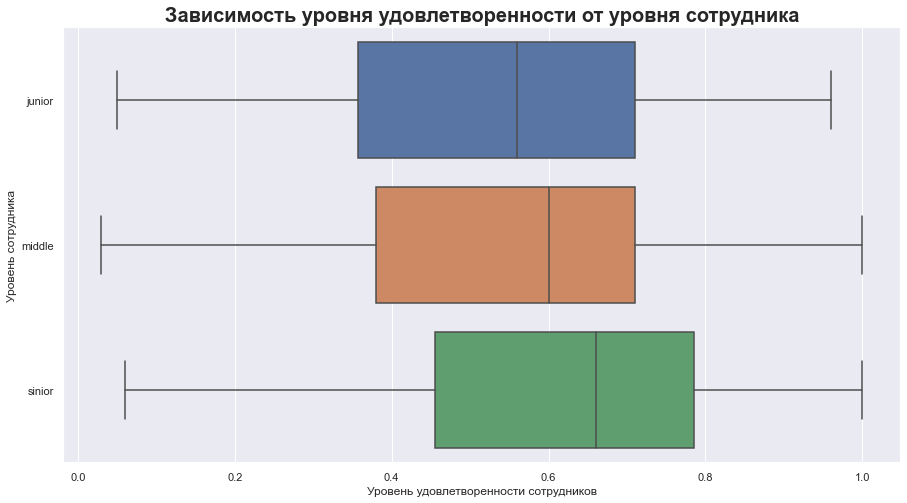

In [51]:
boxplot_creator(test_df,
                'job_satisfaction_rate',
                'level',
                'Зависимость уровня удовлетворенности от уровня сотрудника',
                'Уровень удовлетворенности сотрудников',
                'Уровень сотрудника',
               )

Тут уже закономерность немного изменилась, теперь самый высокий уровень удовлетворенности у сеньеров, а самый маленький у джунов. Проверим, может это как-то связано с зарплатами.

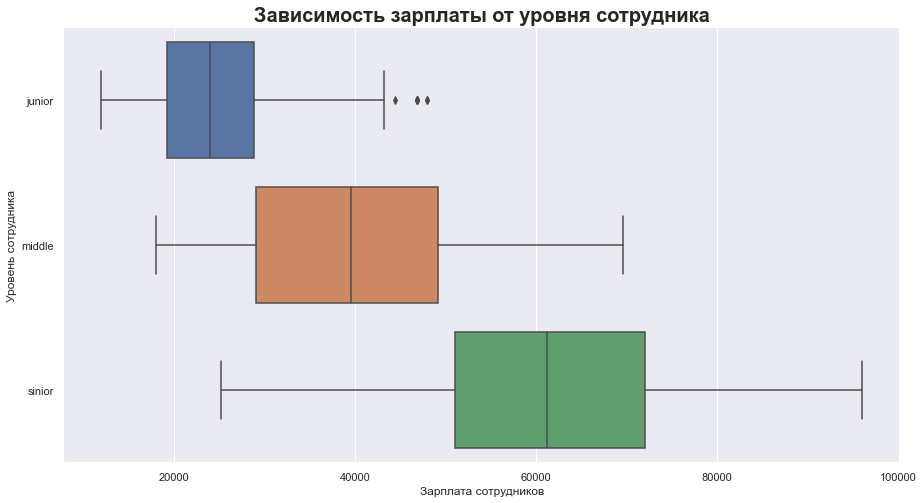

In [52]:
boxplot_creator(test_df,
                'salary',
                'level',
                'Зависимость зарплаты от уровня сотрудника',
                'Зарплата сотрудников',
                'Уровень сотрудника',
               )

Может быть и так, общий уровень зароботка сотрудников стал чуть выше.

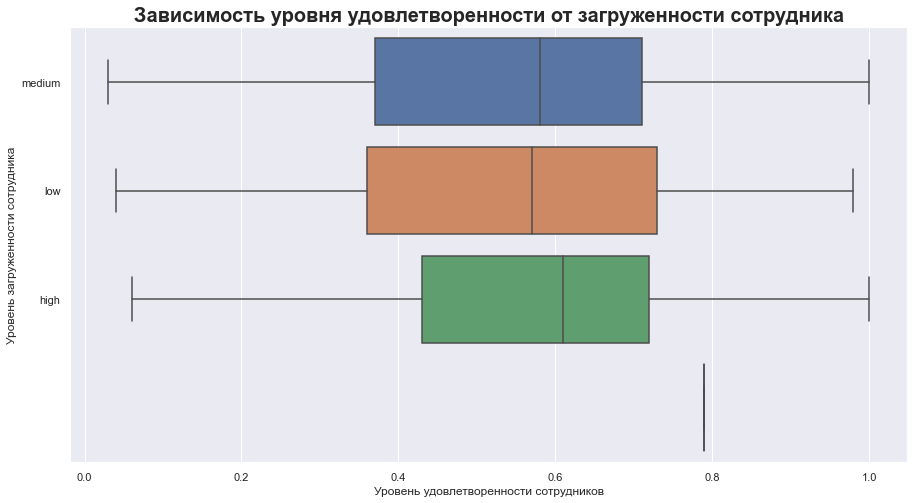

In [53]:
boxplot_creator(test_df,
                'job_satisfaction_rate',
                'workload',
                'Зависимость уровня удовлетворенности от загруженности сотрудника',
                'Уровень удовлетворенности сотрудников',
                'Уровень загруженности сотрудника'
               )

Данные немного поменялись, теперь у сотрудников со средней загруженностью удовлетворенность стала немного выше, а у людей с низкой немного ниже, но эта разница не очень значительная.

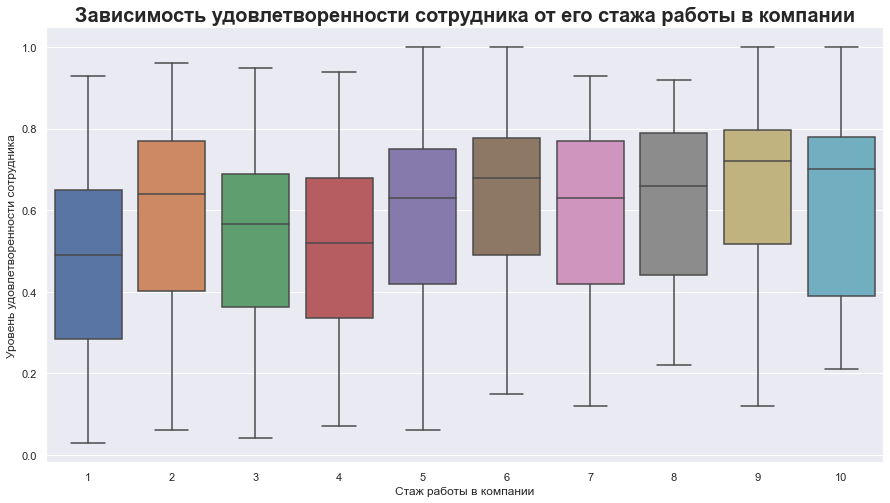

In [54]:
boxplot_creator(test_df,
                'employment_years',
                'job_satisfaction_rate',
                'Зависимость удовлетворенности сотрудника от его стажа работы в компании',
                'Стаж работы в компании',
                'Уровень удовлетворенности сотрудника'
               )

По этому графику видно, что общий уровень удовлетворенности сотрудников стал выше. И тренд на повышение удовлетворенности работой при большем стаже работы в компании стал не таким явным.

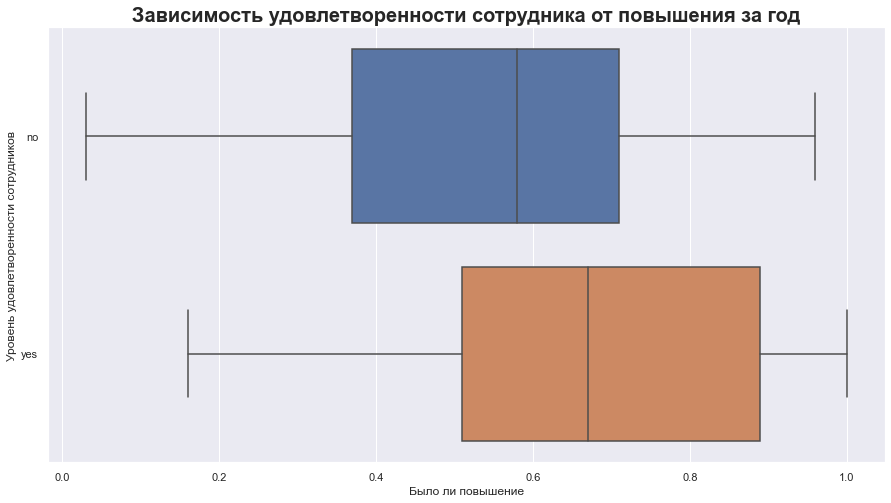

In [55]:
boxplot_creator(test_df,
                'job_satisfaction_rate',
                'last_year_promo',
                'Зависимость удовлетворенности сотрудника от повышения за год',
                'Было ли повышение',
                'Уровень удовлетворенности сотрудников'
               )

Опять же общая удовлетворенность работой возрасла, но у сотрудников получивших повышение за последний год, все еще более высокий коэффициент удовлетворенности работой.

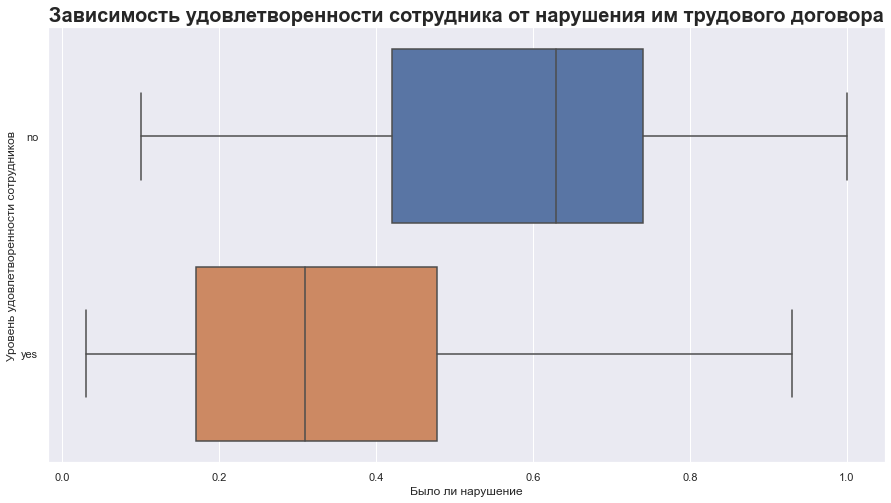

In [56]:
boxplot_creator(test_df,
                'job_satisfaction_rate',
                'last_year_violations',
                'Зависимость удовлетворенности сотрудника от нарушения им трудового договора',
                'Было ли нарушение',
                'Уровень удовлетворенности сотрудников'
               )

В данном параиетре особых изменений нет, разве что уровент удовлетворенности сотрудников не нарушавших условие трудового договора стал немного выше, опять же не значительно.

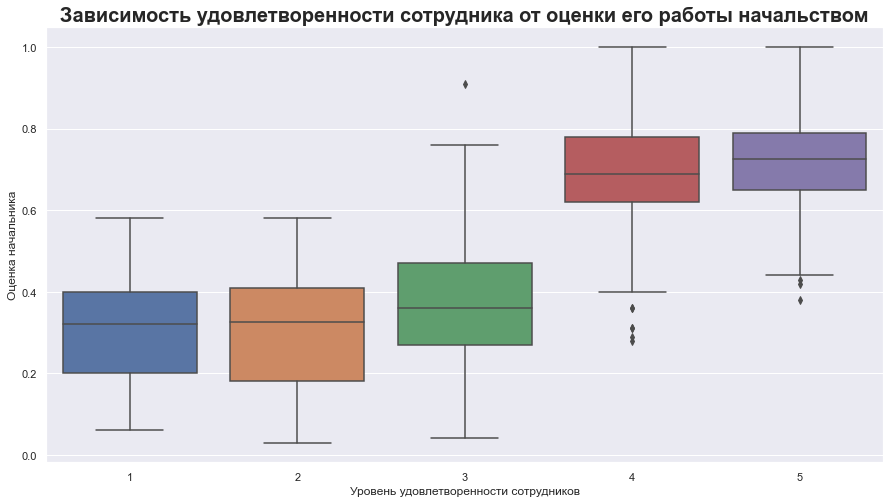

In [57]:
boxplot_creator(test_df,
                'supervisor_evaluation',
                'job_satisfaction_rate',
                'Зависимость удовлетворенности сотрудника от оценки его работы начальством',
                'Уровень удовлетворенности сотрудников',
                'Оценка начальника'
               )

В данном параметре тоже ничего особо не изменилось, все так же присутсвет граница проходящая между оценкой 3 и 4, хвост выбросов у 4-ки стал чуть меньше. И снова виден небольшой рост общей удовлетворенности сотрудников во всем датафрейме.

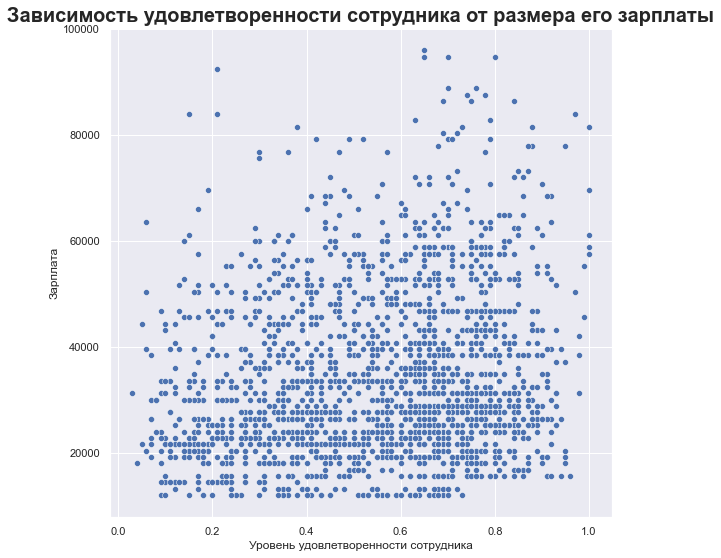

salary  job_satisfaction_rate
salary                 1.000000               0.176579
job_satisfaction_rate  0.176579               1.000000

In [58]:
scatterplot_creator(test_df,
                    'job_satisfaction_rate',
                    'salary',
                    'Зависимость удовлетворенности сотрудника от размера его зарплаты',
                    'Уровень удовлетворенности сотрудника',
                    'Зарплата'
                   )

Тут на глаз более явная зависимость, об этом говорит и совсем небольшое увеличении коэффициента корреляции. Но зависимость все еще очень слабая.

### Вывод по исследовательскому анализу данных

1. ***train_df***
    - Была рассмотрена взаимосвязь всех параметров с целевым признаком
    - В train_df самое большое влияние на целевой признак имеют параметры last_year_violations и last_year_promo
    - От остальных признаков целевой не имеет особо сильной зависимости. Зависимость прослеживается между уровенм сотрудника, его нагруженностью и его зарплатой

2. ***test_df***
    - Была рассмотрена взаимосвязь всез праметров с целевым признком
    - В данном датафрейме явно виден общий рост удовлетворенности сотрудников
    - Столбцы с самым сильным влиянием остались теми же, что и в предыдущем датафрейме
    - Зарплаты сотрудников немного возрасли
    - Зависимость между зарплатой сотрудников и их удовлетворенностью стала чуть более явной
 

## Корреляционный анализ

### train_df

In [59]:
train_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

In [60]:
interval_cols = ['job_satisfaction_rate', 'salary']

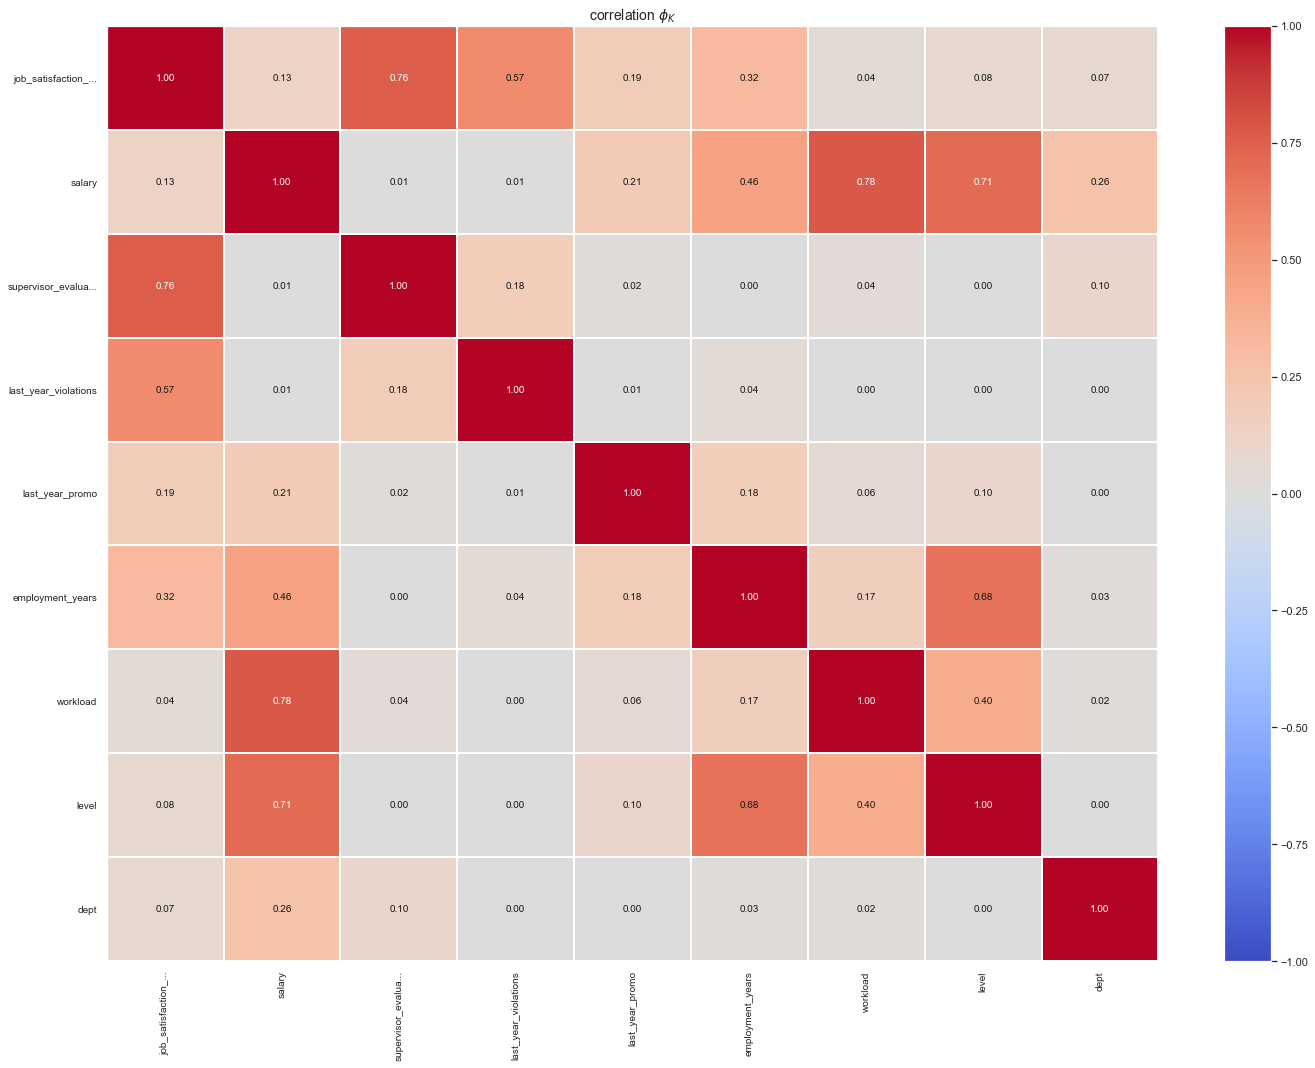

In [61]:
phik_overview = train_df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Столбцы не корреллируют между собой, поэтому мультиколлениарность в данных отсутсвует

### test_df

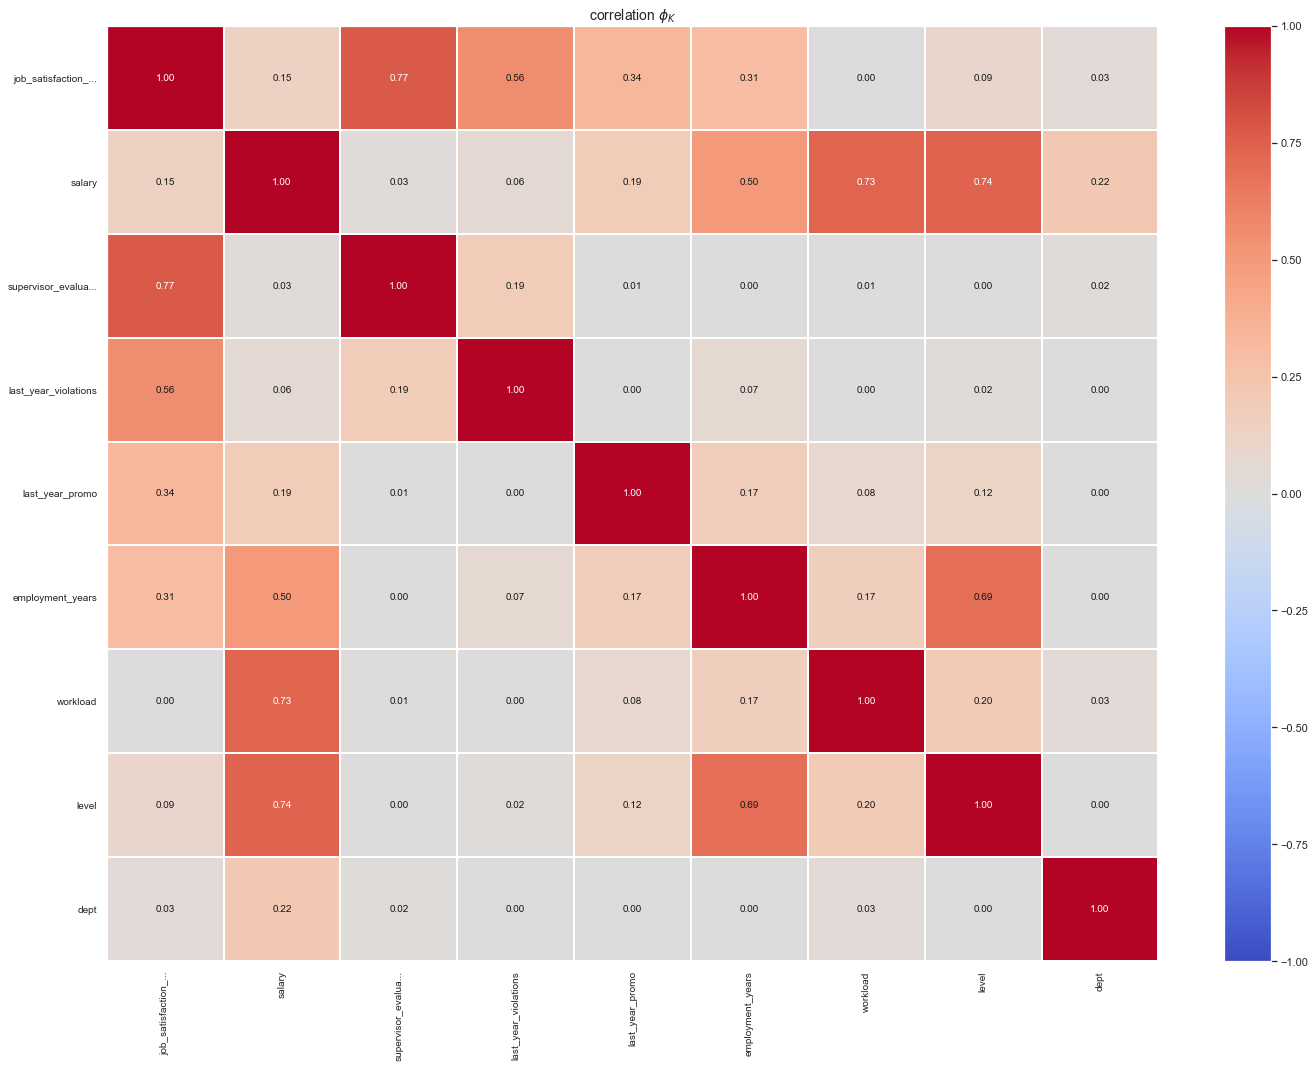

In [62]:
interval_cols = ['job_satisfaction_rate', 'salary']

phik_overview = test_df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$',
    color_map='coolwarm',
    figsize=(20, 15),
) 

В тестовом датафрейме почти все значения коэффициентов корреляции стали выше, но не столько чтобы говорить, что каки-либо столбцы корреллируют между собой, сильно выросла только корреляция с целевым признаком, но это не говрит о мультиколлениарности

### Вывод по корреляционному анализу

Матрицы корреляции показали, что столбцы датафрейма не корреллируют между собой. Мультиколлениарность в данных отсутствует.

## Подготовка данных

Создадим пайплайны для подготовки данных к использованию модели. Создадим функцию SMAPE и сделаем ее метрикой, для изучения качества работы модели.

In [63]:
ohe_cols = ['last_year_promo', 'last_year_violations', 'dept']
ord_cols = ['level', 'workload']

In [64]:
num_cols = list(train_df.select_dtypes(exclude='object').columns)[:-1]
all_cols = num_cols + ord_cols + ohe_cols
target_col = 'job_satisfaction_rate'
num_cols

['employment_years', 'supervisor_evaluation', 'salary']

In [65]:
ohe_pipe = Pipeline(    
    [
        (
            'SimpleimImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),
        (
            'SimpleimImputer_after_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


ord_pipe = Pipeline(
    [
        (            
            'SimpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium','hight']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'SimpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


data_processor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', MinMaxScaler(), num_cols)
    ],
    remainder='passthrough'
)


Итоговый пайплайн для предобработки данных готов. Теперь нужно написать функцию для метрики SMAPE. Я опигу ее в пункте, где размещены все необходимые для прокта фукции написанные мной. А тут останется тольуо создать метрику при помощи написанной выше функции.

In [66]:
def custom_metric(y_true, y):
    n = len(y_true)
    nominator = 2*abs(y_true - y)
    denominator = abs(y_true) + abs(y)
    summa = (nominator/denominator).sum()
    return summa*(100/n)
 
smape= make_scorer(smape_metrics, greater_is_better=False)

Метрика готово. Значение greater_is_better=False потому что чем меньше метрика для тем лучше.

### Вввод по подготовке данных

Был создан пайплайн, который полностью подготовит наши данные к использованию модели. В пайплайне используются такие методы, как: OrdinalEncoder, OneHotEncoder, MinMaxScaler. Так же на этапе подбора модели будет испольоваться StandardScaler.

## Создание модели

Создадим словари в которых будт подбираться гиперпараметры для моеделй на этапа поиска лучшей.

In [67]:
RANDOM_STATE = 42

pipe_final = Pipeline(
    [
        ('preprocessor', data_processor),
        ('models', LinearRegression(n_jobs=-1))
    ]
)

param_grid = [
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models' : [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,30),
        'models__max_features': range(2,30),
        'models__min_samples_split': range(2,30),
        'models__min_samples_leaf': range(1,30),
        'models__criterion': ['squared_error', 'poisson', 'friedman_mse', 'absolute_error'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Тепрь пайплайн полностью готов к использованию. Для выбора лучшей модели будем использовать RandomizedSearchCV, так как гиперпараметров у DecisionTreeRegressor достаточно много.

In [68]:
X_train = train_df[all_cols]
y_train =  train_df[target_col]
X_test = test_df[all_cols]
y_test =  test_df[target_col]

rs = RandomizedSearchCV(
    pipe_final,
    param_grid, 
    n_iter=100,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=smape,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print(f'Метрика SMAPE лучшей модели на кросс-валидации равна {round(-rs.best_score_, 2)}%')
print('Лучшая модель и ее гиперпараметры: \n', rs.best_estimator_)

Метрика SMAPE лучшей модели на кросс-валидации равна 15.44%
Лучшая модель и ее гиперпараметры: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleimImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('SimpleimImputer_after_ohe',
                                                                   Simpl

Посмотрим какие призаки сильнее всего влияют на результат работы модели

In [69]:
y_test_pred = rs.best_estimator_.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке равна {round(custom_metric(y_test, y_test_pred), 2)}%')

Метрика SMAPE на тестовой выборке равна 13.62%


Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


Стоит уточнить, что как раз те два значения '' и ' ' заменились на 0.

Отлично метрика удовлетворяет условию задачи. На тестовой выборке метрика показала среднее процентное отклонение равное 13.62%, а в условии задачи значение должно было быть меньше или равно 15%. 

Модель готова, теперь можно для наглядности добавить результат ее работы отдельным столбцом к тестовому датафрейму. И сохранить результат работы всех проверенных моделей в отдельный датафрейм. Так же посмотреть какие параметры сильнее всего влтят на результат работы модели.

PermutationExplainer explainer: 2588it [03:12, 12.69it/s]                                                              


(2587, 12)

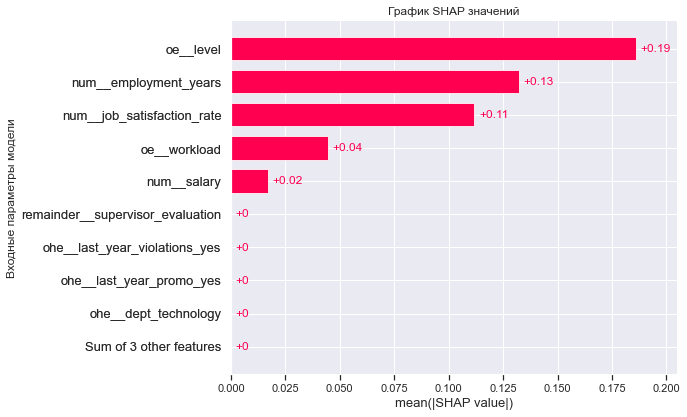

In [121]:
warnings.filterwarnings('ignore')

X = rs.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = rs.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(rs.best_estimator_['models'].predict, X, n_jobs=5)
shap_values = explainer(X)
display(shap_values.values.shape)
shap.plots.bar(shap_values, show=False)
plt.title('График SHAP значений')
plt.ylabel('Входные параметры модели')
plt.show()

Cильнее всего влияют оценка начальства, стаж работы в компании, должность и зарплата.

In [71]:
results = pd.DataFrame(rs.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']]
results.loc[:, 'mean_test_score'] = -results['mean_test_score'] 
results = results.sort_values(by='rank_test_score')
results.head()

params  mean_test_score  \
32  {'preprocessor__num': 'passthrough', 'models__...        15.439245   
19  {'preprocessor__num': 'passthrough', 'models__...        15.528050   
55  {'preprocessor__num': MinMaxScaler(), 'models_...        15.529376   
27  {'preprocessor__num': MinMaxScaler(), 'models_...        15.720340   
41  {'preprocessor__num': StandardScaler(), 'model...        15.813309   

    rank_test_score  
32                1  
19                2  
55                3  
27                4  
41                5

In [72]:
test_df['job_satisfaction_rate_predicted'] = y_test_pred
test_df.sample(5)

dept   level workload  employment_years last_year_promo  \
id                                                                      
727880  technology  junior   medium                 1              no   
562636          hr  junior     high                 1              no   
865135   marketing  middle      low                 5              no   
718694          hr  middle     high                 3              no   
338167  purchasing  junior   medium                 4              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
727880                   no                      5   26400   
562636                   no                      4   33600   
865135                  yes                      4   26400   
718694                   no                      4   51600   
338167                   no                      3   21600   

        job_satisfaction_rate  job_satisfaction_rate_predicted  
id                                                              
727880                   0.57                         0.544000  
562636                   0.50                         0.562000  
865135                   0.42                         0.695714  
718694                   0.49                         0.563333  
338167                   0.38                         0.311667

Судя по пяти ранодомным занчениям из полученного датафрейма модель работает достаточно точно!

# Вывод по задаче 1
В данной задаче был проделан большой объем работы для подготовки данных, для их последующей роботы с моделью. При помощи RabdomizedSearchCV была подобрана модль с лучшей метрикой SMAPE  ей оказалась модель DecisionTreeRegressor с гиперпараметрами:
- criterion='poisson'
- max_depth=22
- max_features=15
- min_samples_leaf=3
- min_samples_split=10

Ее результат на тестовой выборке равен 15.44% на тестовой выборке и 13.62% на тренировочной (это говорит о том что среднее абсолютное отклонение предсказанного занчения от истинного составляется n-ое количиство процентов).

Так же подбирались скейлеры и энкодеры. Так же производился выбор между моделью LinearRegression, но судя по результатам подбора она показала себя хуже. Это скорее всего вызвано тем, что данные не имеют сильной линейной связи с целевым признаком - это было видно еще на моменте исследовательского анализа. Скорее всего результат (коэффициент удовлетворенности сотрудников работой) складывается из общего портрета работника, поэтому лучше оказалась модель DecisionTreeRegressor с методом рабоы основанным на подборе условий из которых модель делает вывод о результате.

# Задача 2

## Загрузка и знакомство с данными

In [73]:
try:
    train_q_df = pd.read_csv('datasets/train_quit.csv')
except:
    train_q_df = pd.read_csv('/datasets/train_quit.csv')
train_q_df.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

На превый взгляд никаких проблем в датафрейме нет. Все столбцы названы корректно в snake_case. Дата фрейм с тестовыми параметрами считывать не будем, потому что он тот же самый, что и в первой задаче. Остается считать только датафрейм с целевым признаком.

In [74]:
try:
    test_target_q_df = pd.read_csv('datasets/test_target_quit.csv')
except:
    test_target_q_df = pd.read_csv('/datasets/test_target_quit.csv')
test_target_q_df.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

В этом датафрейме тоже на первый взгляд нет особых проблем - это не может не радовать.

### Вывод по загрузке данных

На первый взгляд для задачи 2 предоставлены данные достаточно высого качетсва. Столбцы в данных названы корректно, критических проблем на первый взгляд нет. Все данные легко перенислись в датафреймы.

## Предобработка данных

### train_q_df

Для начала предлогаю сделать id индексами датафрейма, потом проверить датафрейм на наличие пропусков и явныз дубликатов. После чего уже изучим распределение всех столбцов.

Но для начала сохраним размер датафрейма до предобработки, чтобы понять какой процент данных мы потеряли.

In [75]:
train_q_df_before_treatments = train_q_df.shape[0]
train_q_df_before_treatments

4000

In [76]:
train_q_df.set_index('id', inplace=True)
train_q_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no

In [77]:
print(f'Число явных дубликатов в датафрейме train_q_df: {train_q_df.duplicated().sum()}')

Число явных дубликатов в датафрейме train_q_df: 1413


Да, дубликатов очень много, почти половина данных, но что поделать - дубликаты только ухудшат результат работы нашей модели в перспективе, поэтому все что мы можем с ними сделать - это удалить их.

In [78]:
train_q_df.drop_duplicates(inplace=True)
print(f'Число явных дубликатов в датафрейме train_q_df: {train_q_df.duplicated().sum()}')

Число явных дубликатов в датафрейме train_q_df: 0


In [79]:
print('Число пропусков в данных по столбцам:')
train_q_df.isna().sum()

Число пропусков в данных по столбцам:


dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [80]:
train_q_df.dtypes

dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
quit                     object
dtype: object

Хорошо, что в днных нет пропущенных значений.

Можно переходить к изучению распределения данных.

In [81]:
profile_train_q_df = ProfileReport(train_q_df, title="Profiling report for train_q_df")
profile_train_q_df.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

1. **dept**
    - Большинство сотрудников работают в отделе продаж - 31.1% от всех работников
    - На втором месте отдел технологий - 22.5% от всех рабочих
    - Меньше всего работников HR отдела их всего 13.5% от всех рабочих
2. **level**
    - Больше всего работников на должности мидлов - 49.6% от всех данных
    - Чуть меньше джунов - 37.0%
    - Меньше всего сеньйоров - 13.4%
3. **workload**
    - У большинства работников средняя занятость - у 48.1% от всех рабочих
    - На втором месте работники с низкой занятостью - 28.8% от всех рабочих
    - Меньше всего работников с высокой занятостью - 23.1% от всех рабочих
4. **emoloyment_years**
    - У большинства сотрудников низкий стаж работы в этой компании
    - Средний стаж работы в компании равен 4 года
    - Медианное значение тоже равно 4
5. **last_year_promo**
    - Большинство сотрудников не получили повышения в прошедшем году - 95.7%
    - Всего 4.3% сотрудников получили повышение за прошедший год
6. **last_year_violations**
    - Большая часть сотрудников не нарушала условия трудового договора - 81.6%
    - Достаточно много сотрудников нарушали трудовой договор - 18.4%
7. **supervisor_evaluation**
    - Большая часть сотрудников имеет оценку 4 от начальника - 34.1%
    - На втором месте троешники - их 32.4%
    - Отличников 14.3%
    - Меньше всего работников работа которыех оценена на 1 - их 6.6%
8. **salary**
    - Распределение зарплат выглядит нормально, но с небольшим смещение влево
    - Средняя зарплата равна примерно 37.1 т.р
    - Медианная 33.6 т.р. такая разниа между средним и медианой обусловлена "хвостом из высоких зарплат"
    - Минимальная зарплата равна 12 т.р.
    - Максимальная 96 т.р.
    - У большинства сотрдуников зарплата меньше 70 т.р.
9. **quit**
    - Большинство сотрудников остались в компании - 74.7%
    - Но все равно, достаточно большой процент сотрудников уволился - целых 25.3%
    
Теперь небходимо узначть какой процент данных мы потеряли на этапе предобработки.

In [82]:
1 - train_q_df.shape[0] / train_q_df_before_treatments 

0.35324999999999995

Мы потеряли 35% данных - это много, но это полные дубликаты, которые испортили бы работу модели, поэтому пришлось с ними расстаться.

### test_target_q_df

Сначала сделаем id индексами датафрейма. И смысла смотреть полные дубликаты не будет, потому что их будет много, так как в датафрейме два значения "да" и "нет". Стоить только проверить данные на наличеие пропущенных значений.

In [83]:
test_target_q_df.set_index('id', inplace=True)
test_target_q_df.head()

quit
id         
999029  yes
372846   no
726767   no
490105   no
416898  yes

In [84]:
print('Число пропущенных значений')
test_target_q_df.isna().sum()

Число пропущенных значений


quit    0
dtype: int64

Отлично, пропущенных значений в этом датафрейме нет.

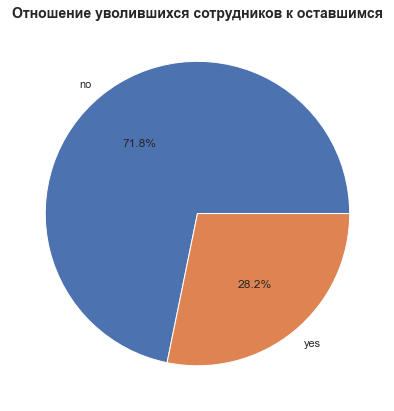

In [85]:
pie_creator(test_target_q_df, 'quit', 'Отношение уволившихся сотрудников к оставшимся')


Большая часть сотрудников осталась работать в компании - 71.8%. Но целых 28.2% сотрудников ушли их компании - это достаточно много.

### Вывод по предобработке данных
Для изучения были предоставлены данные достаточно высокого качества, не учитывая датафрейма train_q_df - в нем было очень много полных дубликатов. Резюмируя:
- Тренировочный датафрейм был очищен от полных дубликатов, на этом этапе мы потеряли 35% данных - это много
- Были изучены распределения параметров тренировочного датафрейма и датафрейма с целевым признаком, аномальных значений не обнаруженно
- Более подробное описание распределенений можно посмотреть на этапе предобработке в пункте с интересующим названием датафрейма


## Исследовательский анализ данных. Составление портрета уволившегося сотрудника

Сначала проведем исследовательский анализ и изучим как столбцы связаны с целевым признаком. Потом уже составим портрет уволившегося сотрудника.

### train_q_df

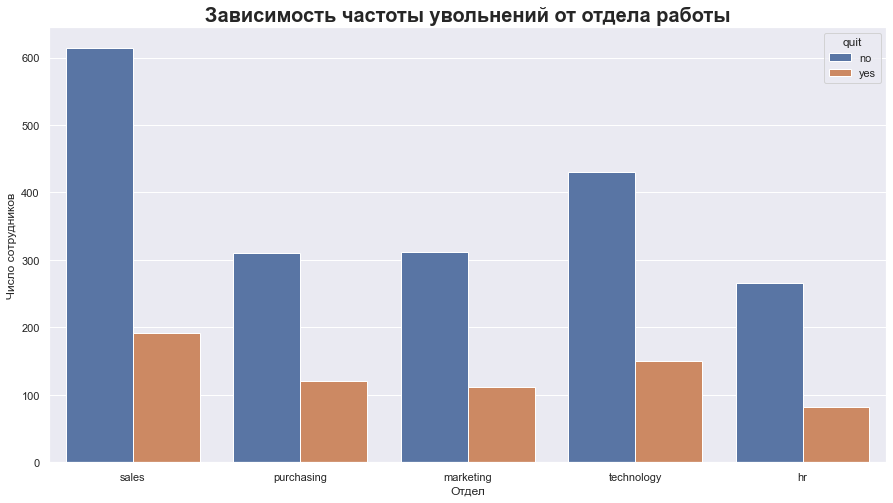

In [86]:
countplot_creator(train_q_df,
                  'dept',
                  'quit',
                  'Зависимость частоты увольнений от отдела работы',
                  'Отдел',
                  'Число сотрудников'
                 )

Тут нет никакой интересной зависимости, из всех отделов уходит примерно одинаковая доля сотрудников. Больше всего сутрудников уволилось их отдела, продаж, но он значительно больше других, так что это мало о чем нам может сказать.

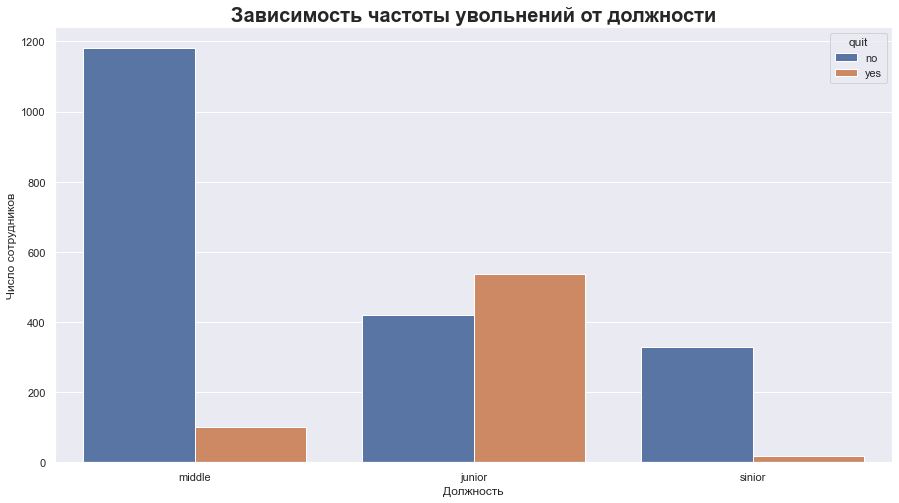

In [87]:
countplot_creator(train_q_df,
                  'level',
                  'quit',
                  'Зависимость частоты увольнений от должности',
                  'Должность',
                  'Число сотрудников'
                 )

Вот тут уже очень интересная закономерность. Чаще всего увольняются джуниор специалисты, доля уволившихся в этой категории больше чем доля оставшихся в компании, мидлы увольняются очень редко, а сеньеры вообще почти не уходят из компании. И так, джуниор специалисты попадают в зону риска.

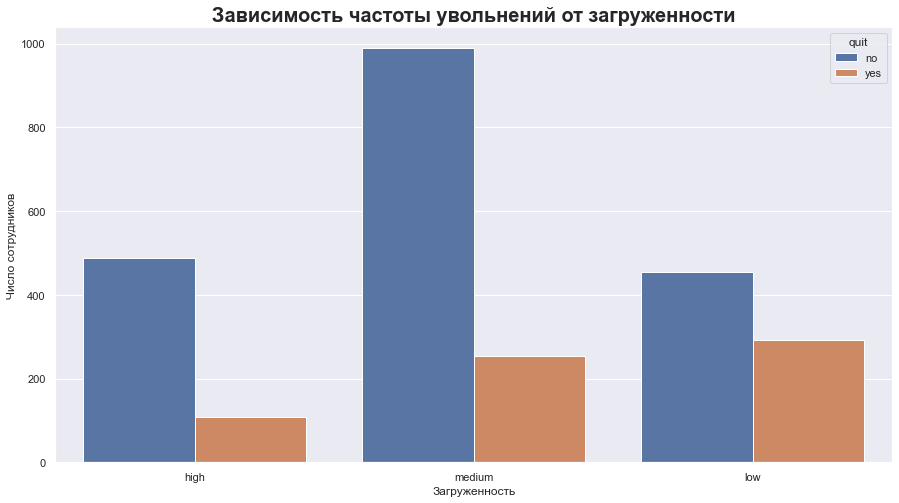

In [88]:
countplot_creator(train_q_df,
                  'workload',
                  'quit',
                  'Зависимость частоты увольнений от загруженности',
                  'Загруженность',
                  'Число сотрудников'
                 )

Самая большая доля уволившихся приходится на работников с низкой загруженностью, логично предположить, что это джуны. Сотрудники со средней загруженностью увольняются примерно с такой же частотой, но их намного больше, поэтому доля уволившихся небольшая. Сотрудники с высокой загруженность увольняются редко. Ито: в зону риска попадают пользователи с низкой загруженностью.

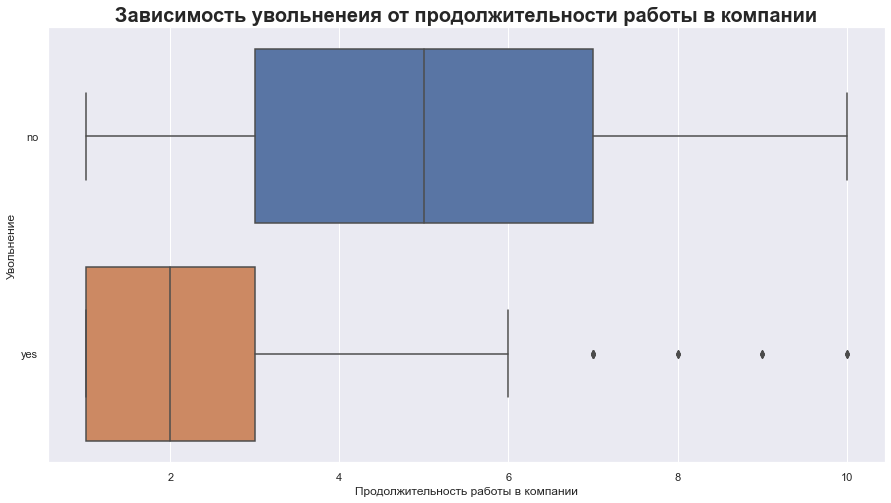

In [89]:
boxplot_creator(train_q_df,
                    'employment_years',
                    'quit',
                    'Зависимость увольненеия от продолжительности работы в компании',
                    'Продолжительность работы в компании',
                    'Увольнение'
                   )

По графику видно, чем меньше пользователь работает в данной компании тем более велик шанс, что он уволится. Пользователи пропаботавшие более шести лет почти не увольняются. В зону риска попадают пользователи которые мало проработали в компании. 

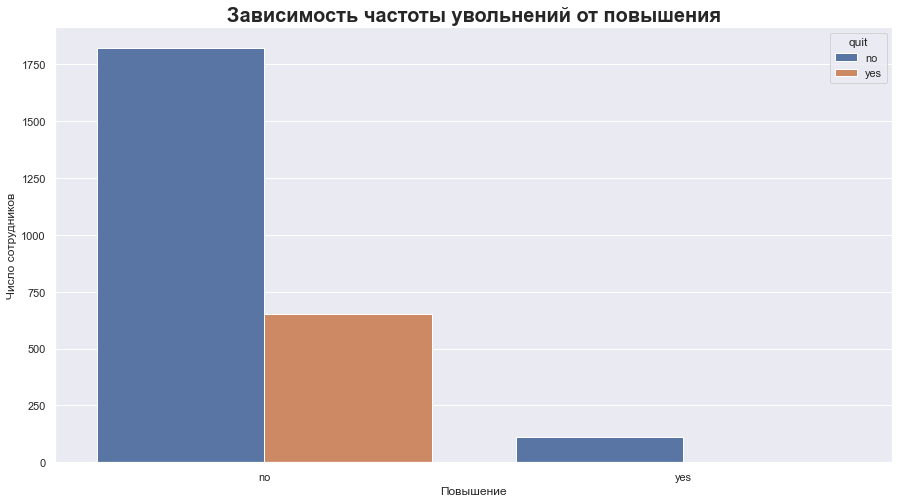

In [90]:
countplot_creator(train_q_df,
                  'last_year_promo',
                  'quit',
                  'Зависимость частоты увольнений от повышения',
                  'Повышение',
                  'Число сотрудников'
                 )

Тут есть небольшая зависимость, которая скорее всего сильно повлияет на модель, но она достаточно важная. По графику видно, что сотрудники, которые получили повышение в прошедшем году вообще не увольнялись из компании. Увольнялись тольуо сотрудники не получившие повшение, но их доля не очен большая.

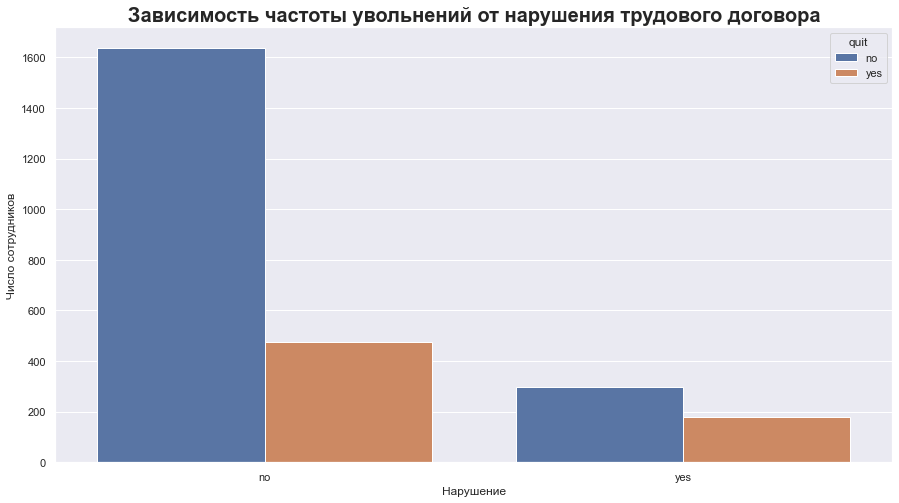

In [91]:
countplot_creator(train_q_df,
                  'last_year_violations',
                  'quit',
                  'Зависимость частоты увольнений от нарушения трудового договора',
                  'Нарушение',
                  'Число сотрудников'
                 )

Часть сотрудников нарушивших трудовой договор и ушедгих с работы достаточно большая относительно своей категории. Доля пользователей, котоыре не нарушали договор и ушли с работы не такая большая. Итог: в зоне риска пользователи которые нарушали трудовой договор.

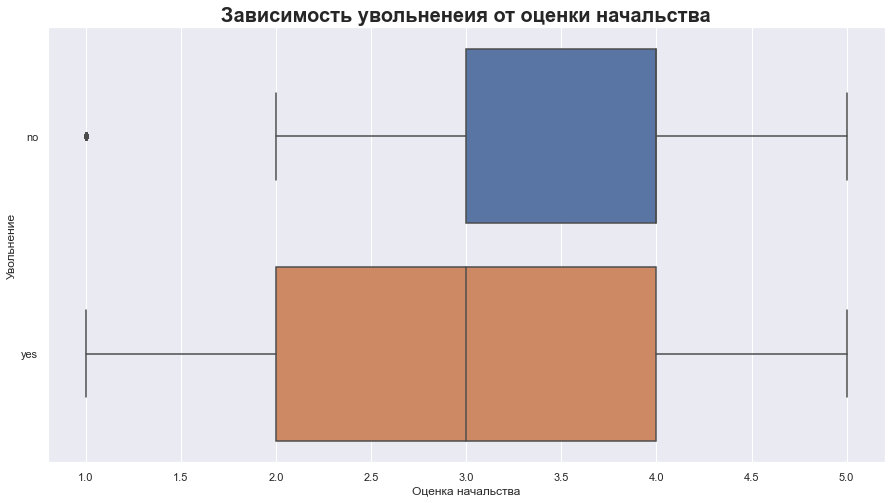

In [92]:
boxplot_creator(train_q_df,
                    'supervisor_evaluation',
                    'quit',
                    'Зависимость увольненеия от оценки начальства',
                    'Оценка начальства',
                    'Увольнение'
                   )

Тут вырисовывается достаточно интересная закономерность. Пользователи которые уволились с работы не особо зависят от оценки начальства, но вот пользователи оставшиеся в компании в основном имеют от начальства оценку выше средней, звучит странно, но график говорит сам за себя.

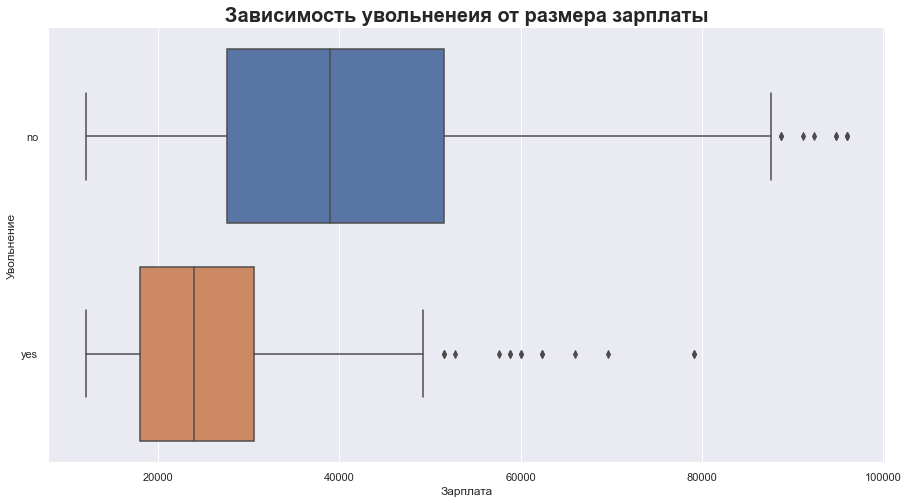

In [93]:
boxplot_creator(train_q_df,
                    'salary',
                    'quit',
                    'Зависимость увольненеия от размера зарплаты',
                    'Зарплата',
                    'Увольнение'
                   )

По графику видно, что чем меньше зарплата, тем больше шанс того, что пользователь уволится с работы. Скорее всего в этом есть связь между должностью, загруженность и отделом. Опять же график говорит что, далеко не все пользователи с маленькой зарплатой увольняются.

### Объединене датафреймов

Для удобства нахождения взаимосвязей объединим датафрейм test_features_df и test_target_q_df.

In [94]:
test_q_df = test_features_df.merge(test_target_q_df, on='id')
test_q_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
485046                   no                      5   28800   no  
686555                   no                      4   30000   no  
467458                   no                      4   19200   no  
418655                   no                      4   19200   no  
789145                   no                      5   40800   no

Отлично, объединение выполнено.

### test_q_df

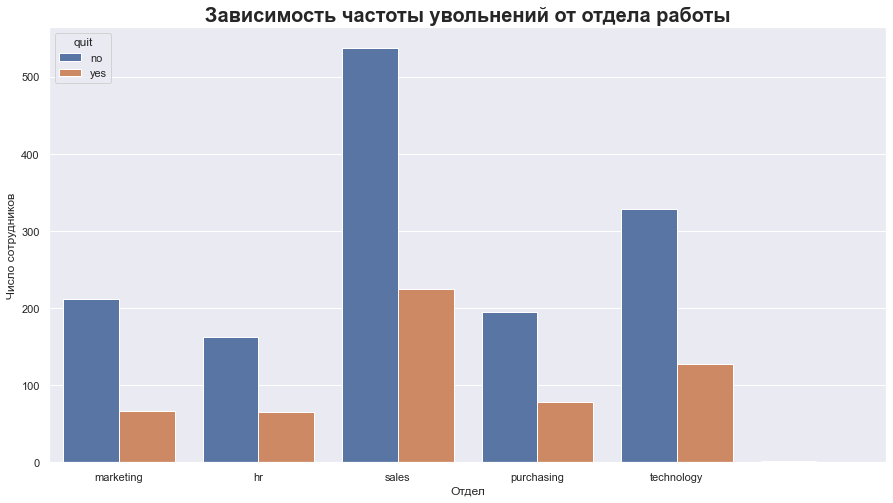

In [95]:
countplot_creator(test_q_df,
                  'dept',
                  'quit',
                  'Зависимость частоты увольнений от отдела работы',
                  'Отдел',
                  'Число сотрудников'
                 )

Тут распределение примерно такое же как и на тренировчной выборке. Ничего необычного.

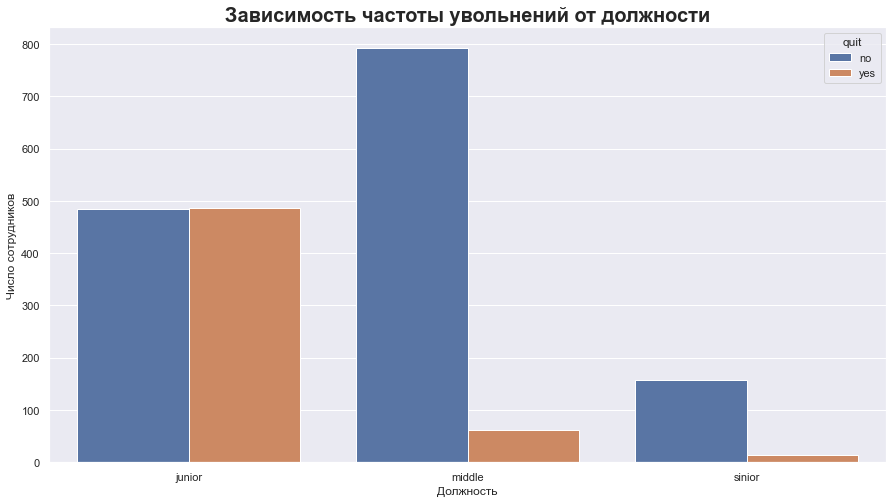

In [96]:
countplot_creator(test_q_df,
                  'level',
                  'quit',
                  'Зависимость частоты увольнений от должности',
                  'Должность',
                  'Число сотрудников'
                 )

Тут опять же в самой большой зоне риска джуниоры. Джуниоров, которые уволились чуть больше чем тех кто не уволился. Мидлы и сениоры увольняются очень редко

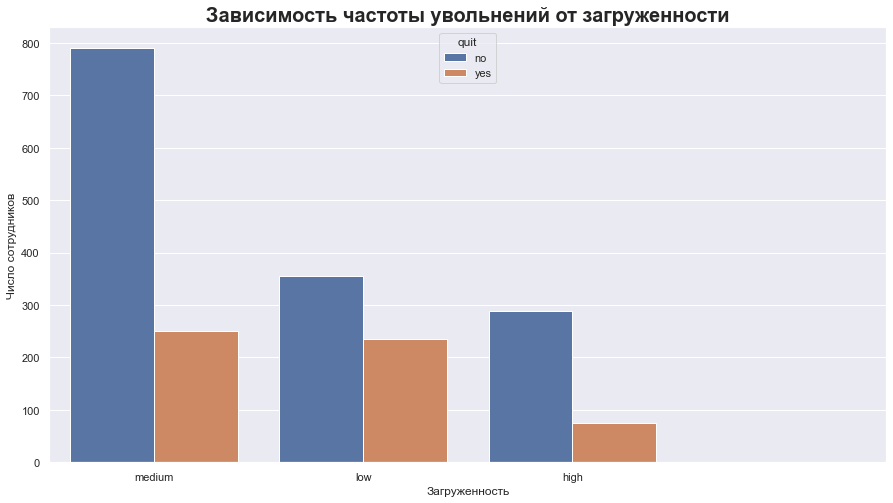

In [97]:
countplot_creator(test_q_df,
                  'workload',
                  'quit',
                  'Зависимость частоты увольнений от загруженности',
                  'Загруженность',
                  'Число сотрудников'
                 )

Самая большая часть увольнений приходится все так же на сотрудников с низкой загруженностью. Доля уволившихся со средней и высокой загруженностью не такая большая. В зоне риска пользователи с низкой загруженностью, скорее всего это джуны.

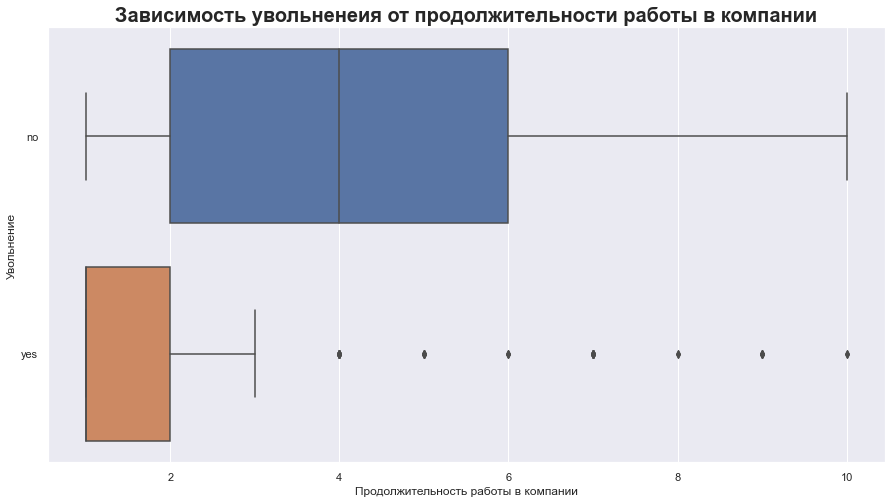

In [98]:
boxplot_creator(test_q_df,
                'employment_years',
                'quit',
                'Зависимость увольненеия от продолжительности работы в компании',
                'Продолжительность работы в компании',
                'Увольнение'
                )

Все так же как и в предыдущем датафрейме. Большую вероятность увольнения имеют работники с низким стажем работы в компании. Большинство работников имеет стаж работы от 2 до 4 лет.

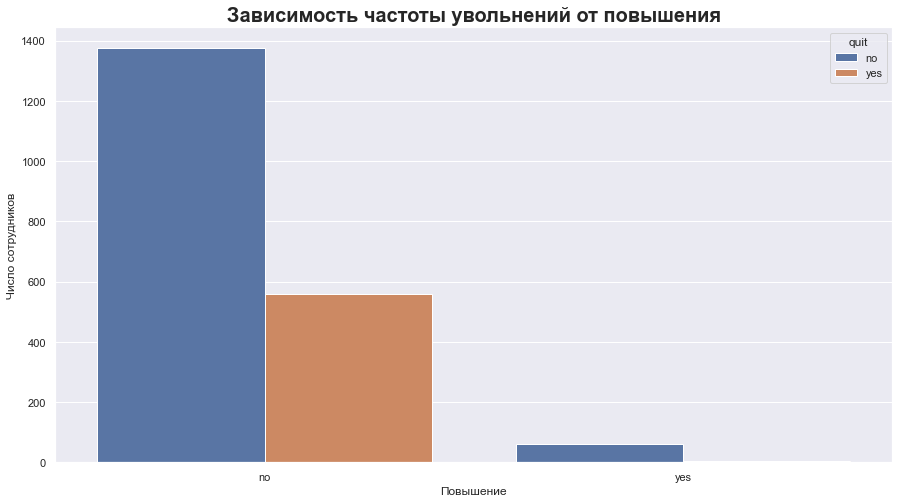

In [99]:
countplot_creator(test_q_df,
                  'last_year_promo',
                  'quit',
                  'Зависимость частоты увольнений от повышения',
                  'Повышение',
                  'Число сотрудников'
                 )

Ситуация точь в точь, как в предыдущем датафрейме. Сотрудники, которые получили повышение за прошедший год не увольняются из компании. Вся доля уволившихся приходится на сотрудников, которые не полуили повышения.

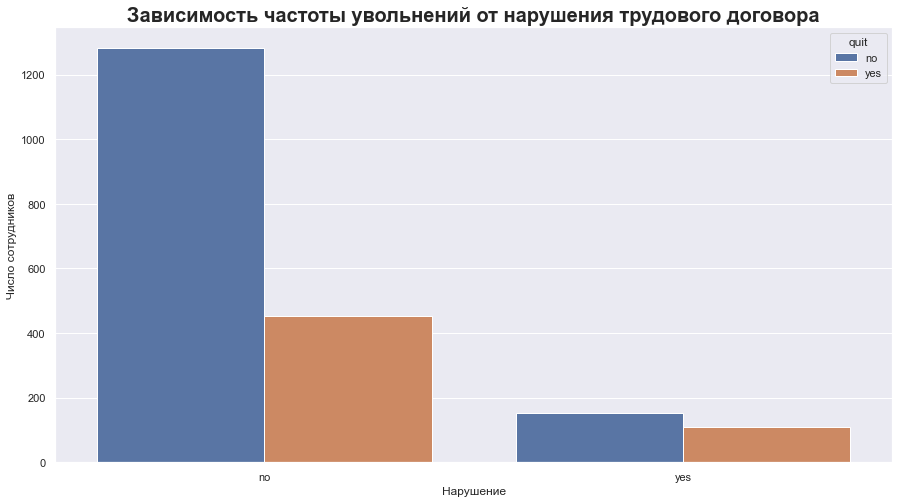

In [100]:
countplot_creator(test_q_df,
                  'last_year_violations',
                  'quit',
                  'Зависимость частоты увольнений от нарушения трудового договора',
                  'Нарушение',
                  'Число сотрудников'
                 )

На этом графики прослеживается та же зависимость, что и на тренировочных данных - доля сотрудников нарушивших договор и уволившихся примерно равна доле оставшихся, конечно сотрудников, которые уволились бех нарушения больше, но в этой категории впринципе гораздо больше людей.

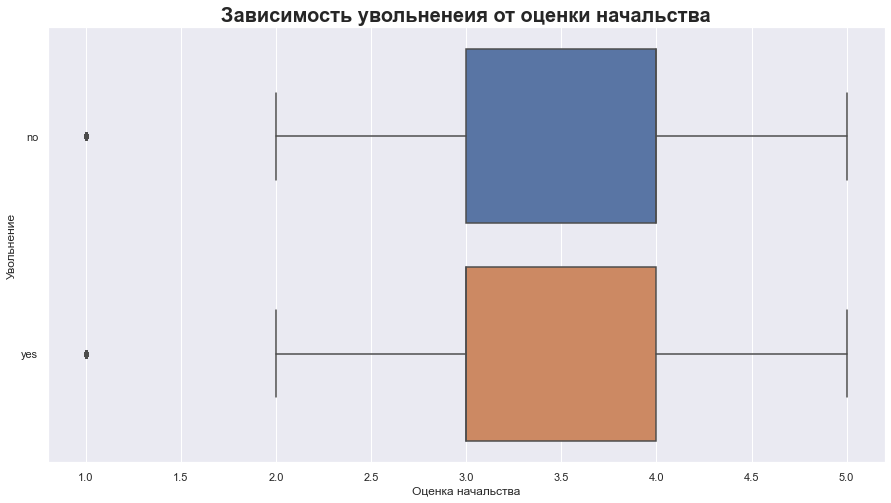

In [101]:
boxplot_creator(test_q_df,
                'supervisor_evaluation',
                'quit',
                'Зависимость увольненеия от оценки начальства',
                'Оценка начальства',
                'Увольнение'
               )

Тут получилось очень странно... Но если верить данным в этом датафрейме совсем нет зависимости от оценки начальника. Оченка никак не влияет на желание работника покинуть свой пост.

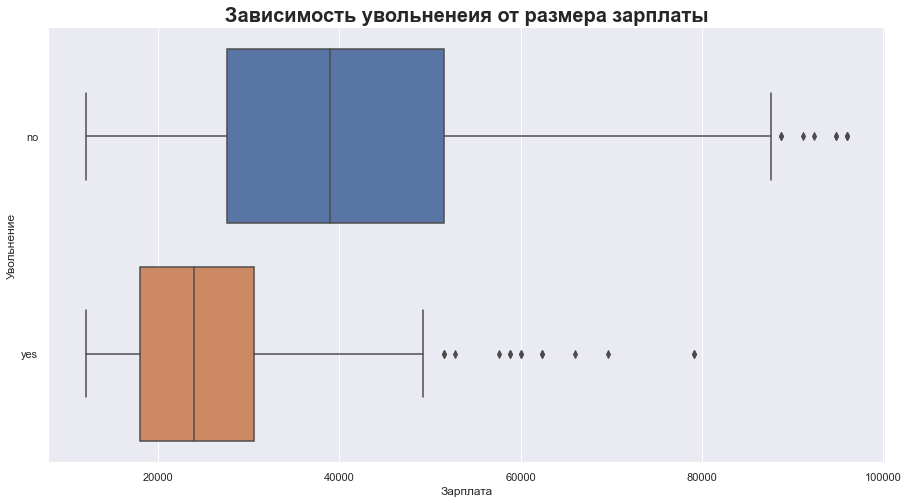

In [102]:
boxplot_creator(train_q_df,
                'salary',
                'quit',
                'Зависимость увольненеия от размера зарплаты',
                'Зарплата',
                'Увольнение'
               )

С этим праметром все, просто люди с маленькой зарплатой чаще увольняются с работы. Все так же как и в предыдущем датафрейме.

### Портрет уволившегося сотрудника

Для начала предлагаю рассмотреть точную информацию о числовых параметрах пользователей, которые уволились в сравнении с оставшимися сотрудниками. Так же изучим процентные соотношения распределение категориальных данных по двум вышеописанным категориям. Изучать будем на тренировочной выборке, хотя особой разницы между выборами нет.

In [103]:
train_q_df.query('quit == "yes"').describe()

employment_years  supervisor_evaluation        salary
count        655.000000             655.000000    655.000000
mean           2.161832               2.958779  25767.938931
std            1.497626               1.047705  10484.828614
min            1.000000               1.000000  12000.000000
25%            1.000000               2.000000  18000.000000
50%            2.000000               3.000000  24000.000000
75%            3.000000               4.000000  30600.000000
max           10.000000               5.000000  79200.000000

In [104]:
train_q_df.query('quit == "no"').describe()

employment_years  supervisor_evaluation        salary
count       1932.000000            1932.000000   1932.000000
mean           4.908903               3.506729  40952.173913
std            2.527730               1.055898  16085.739667
min            1.000000               1.000000  12000.000000
25%            3.000000               3.000000  27600.000000
50%            5.000000               4.000000  39000.000000
75%            7.000000               4.000000  51600.000000
max           10.000000               5.000000  96000.000000

In [105]:
obj_cols_train = list(train_q_df.select_dtypes(include='object').columns)[:-1]
obj_cols_train

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [106]:
for col in obj_cols_train:
    print(f'Нормализованное распределение праметра {col} в разрезе целевого признака co значением "no" - не уволился \n',
          train_q_df.query('quit == "no"')[col].value_counts(normalize=True),
          '\n'
         )
    print(f'Нормализованное распределение праметра {col} в разрезе целевого признака co значением "yes" - уволился \n',
          train_q_df.query('quit == "yes"')[col].value_counts(normalize=True),
          '\n')
    print('===================================================================\n')

Нормализованное распределение праметра dept в разрезе целевого признака co значением "no" - не уволился 
 sales         0.317805
technology    0.223085
marketing     0.160973
purchasing    0.160455
hr            0.137681
Name: dept, dtype: float64 

Нормализованное распределение праметра dept в разрезе целевого признака co значением "yes" - уволился 
 sales         0.291603
technology    0.229008
purchasing    0.183206
marketing     0.170992
hr            0.125191
Name: dept, dtype: float64 


Нормализованное распределение праметра level в разрезе целевого признака co значением "no" - не уволился 
 middle    0.611284
junior    0.217909
sinior    0.170807
Name: level, dtype: float64 

Нормализованное распределение праметра level в разрезе целевого признака co значением "yes" - уволился 
 junior    0.819847
middle    0.154198
sinior    0.025954
Name: level, dtype: float64 


Нормализованное распределение праметра workload в разрезе целевого признака co значением "no" - не уволился 
 medi

Отлично, все готово. Данные говорят о том, что большинство пользователей, которые уволились имели стаж работы менее трех лет, имели оценку от начальства 4 или же ниже и зарплату меньше 30 т.р. Стоит заметить, что средняя зарплата сотрудникоа, которые уволились в два раза меньше, чем средняя зарплата пользователей до сих пор работающих в компании. С медианной зарплатой не такое больое расхождение, но разница все равно значительная. Говоря о категориальных параметрах более склонны к увольнению работники из отдела продаж. Так же сотрудники с должностью junior очень склонны увольнению. Так же более склонны к увольнению пользователи с низкой загруженностью. Нарушение трудового договора и повышение не так сильно влияет на увольнение сотрудников, чеще они остаются на рабочем месте.

Вышенаписанное можно было вынести еще из графиков, но точное процентное соотношение позволяет более точно описать как и какие параметры влияют на увольнение сотрудника.

***Портрет уволившегося сотрудника.***

На основе исследовательского анализа данных составм портрет сотрудника, уволившегося из компании:

- С большей вероятностью уволившийся работник принадлежал отделу продаж или же отделу технологий, но стоит напомнить, что этот параметр не так сильно влияет на вероятность увольнения
- Скорее всего этот сотрудник имед должность junior
- Вероятнее всего уволившийся сотрудник будет иметь низукую загруженность
- Скорее всего уволившийся сотрудник проработал в компании менее трех-четырех лет
- Если работник нарушал трудовой договор, то шанс того, что он уйдет с работы возрастает, но не очень сильно
- Сотрудник, работу которого начальник оценивает на два и менее балла более склонен к увольнению
- В основном чем меньше зарплата у пользователя, тем больше шанс, что он уйдет с работы.

### Проверка взаимосвязи между quit и job_satisfaction_rate

Добавим к тестовому датафрейму параметр job_satisfaction_rate, к тестовому, чтобы посмотреть как взаимосвязаны данные и есть ли смысл добовлять этот столбец к тренировочному датафрейму.

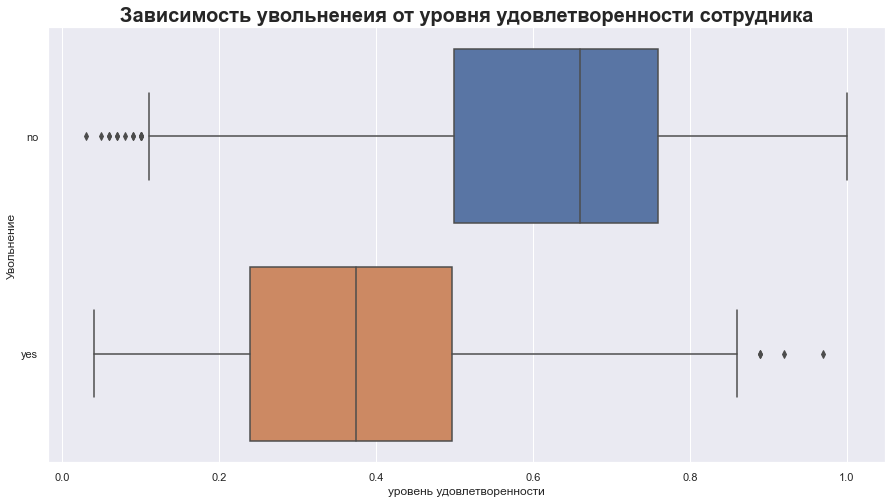

In [109]:
test_q_satisfaction_df = test_q_df.merge(test_target_df, on='id', how='left')
boxplot_creator(test_q_satisfaction_df,
                'job_satisfaction_rate',
                'quit',
                'Зависимость увольненеия от уровня удовлетворенности сотрудника',
                'уровень удовлетворенности',
                'Увольнение'
               )

По графикам видна зависимость, что чем более сторудник удовлетворен работой, тем меньше шанс, что он удйдет с нее. Следовательно этот параметр действительно может помочь модели в определении сотрудников, которые могут уволиться. Есть только одна проблема, у нас нет параметра job_satisfaction_rate, для тренировочного датафрейма, но у нас есть модель которая достаточно точно его предсказывает, похоже пора воспользоваться ей.

Так же стоит уточноить, что к портрету уволившегося сотрудника добавится еще один критерей - чем меньше уровень удовлетворенности сотрудника, тем больше шанс на то, что он уволится.

### Добавление нового входного признака

In [110]:
train_q_df['job_satisfaction_rate'] = rs.best_estimator_.predict(train_q_df)
test_q_df = test_q_df.merge(test_target_df, on='id', how='left')
test_q_df.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary quit  \
id                                                                
485046                   no                      5   28800   no   
686555                   no                      4   30000   no   
467458                   no                      4   19200   no   
418655                   no                      4   19200   no   
789145                   no                      5   40800   no   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75

### Вывод по исследовательскому анализу данных

На этапе исследовательского анализа были проверены взаимосвязи всех параметров с целевым признаком, так же было проверено влияние параметра job_satisfaction_rate на целевой признак, судя по графикам этот параметр может помочь модели в предсказаниях. Для добавления его в тренировочный датафрейм использовалась модель из предыдущей задачи. Так же был составлен портрет уволившегося сотрудника, резюмируя по каждому мз пунктов

1. ***train_q_df***
    - Была рассмотрена взаимосвязь всех параметров с целевым признаком
    - В train_df самое большое влияние на целевой признак имеют параметры level, workload, last_year_promo и employment_years
    - От остальных признаков целевой признак тоже зависит, но не так явно как от этих входных параметров

2. ***test_df***
    - Была рассмотрена взаимосвязь всез праметров с целевым признком
    - Столбцы с самым сильным влиянием остались теми же, что и в предыдущем датафрейме
3. ***Добавление входного признака***
    - Чем больше удовлетворенность сотрудника тем меньше шанс, что он уволится 
4. ***Портрет уволившегося сотрудника***
    - С большей вероятностью уволившийся работник принадлежал отделу продаж или же отделу технологий, но стоит напомнить, что этот параметр не так сильно влияет на вероятность увольнения
    - Скорее всего этот сотрудник имед должность junior
    - Вероятнее всего уволившийся сотрудник будет иметь низукую загруженность
    - Скорее всего уволившийся сотрудник проработал в компании менее трех-четырех лет
    - Почти стопроцентно уволившийся сотрудник не получил никакого повышения за предыдущий год
    - Если работник нарушал трудовой договор, то шанс того, что он уйдет с работы возрастает в разы
    - Сотрудник, работу которого начальник оценивает на два и менее балла более склонен к увольнению
    - В основном чем меньше зарплата у пользователя, тем больше шанс, что он уйдет с работы
    - Скорее всего у сотрудника будет маленький уровень удовлетворенности работой

## Корреляционный анализ

### train_q_df

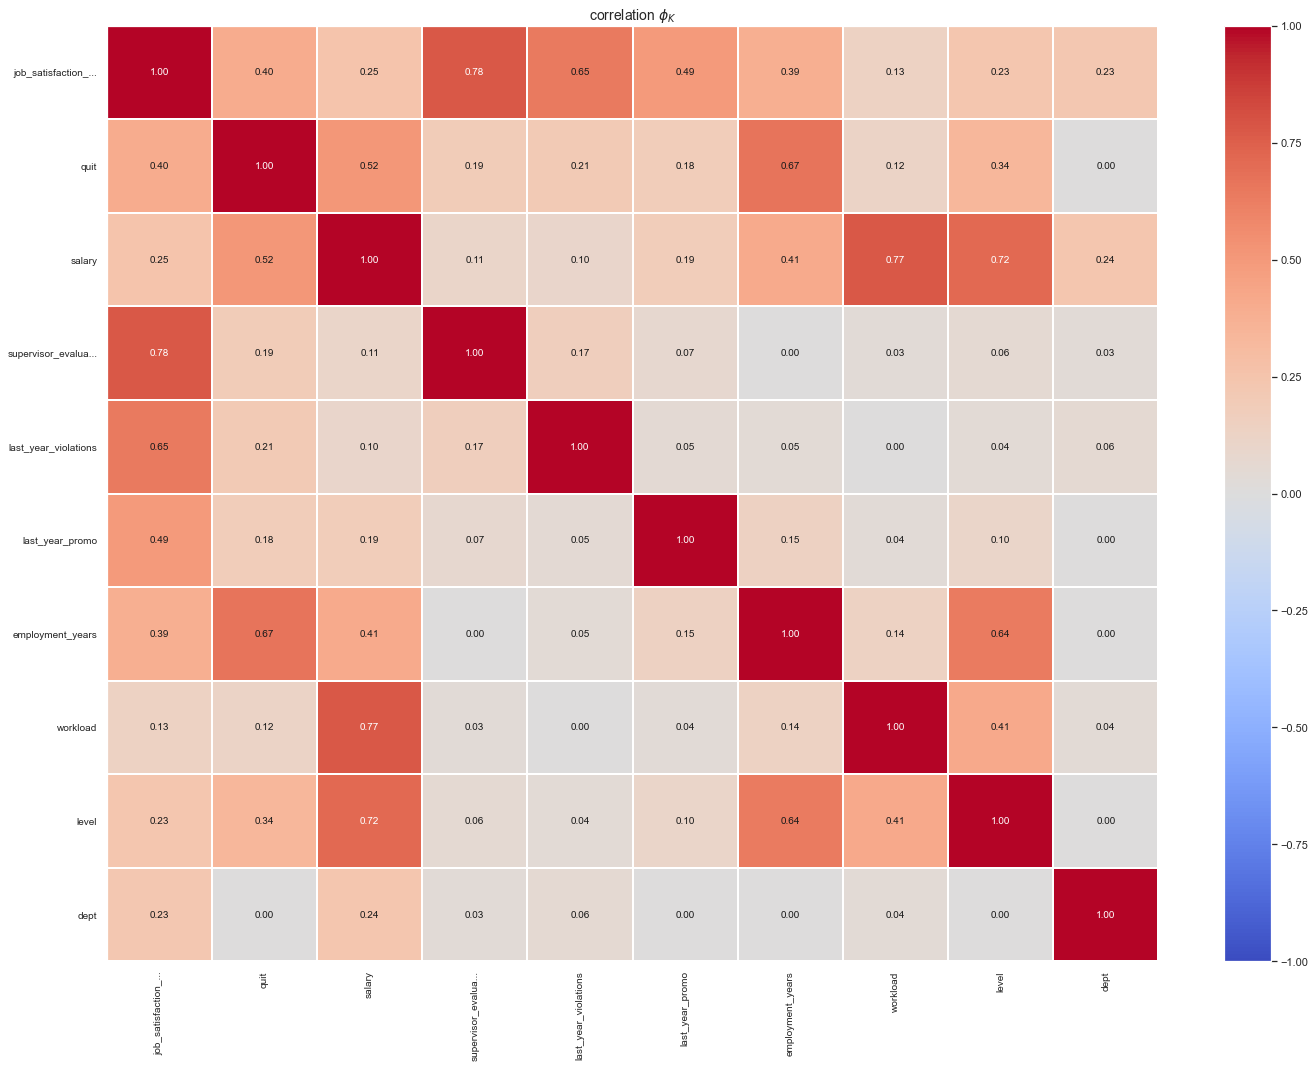

In [111]:
interval_cols = ['job_satisfaction_rate', 'salary']

phik_overview = train_q_df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Высокой принято считать корреляцию более чем 0.9, в нашем датафрейме таковая отсутствует, следовательно мультиколлениарность тоже.

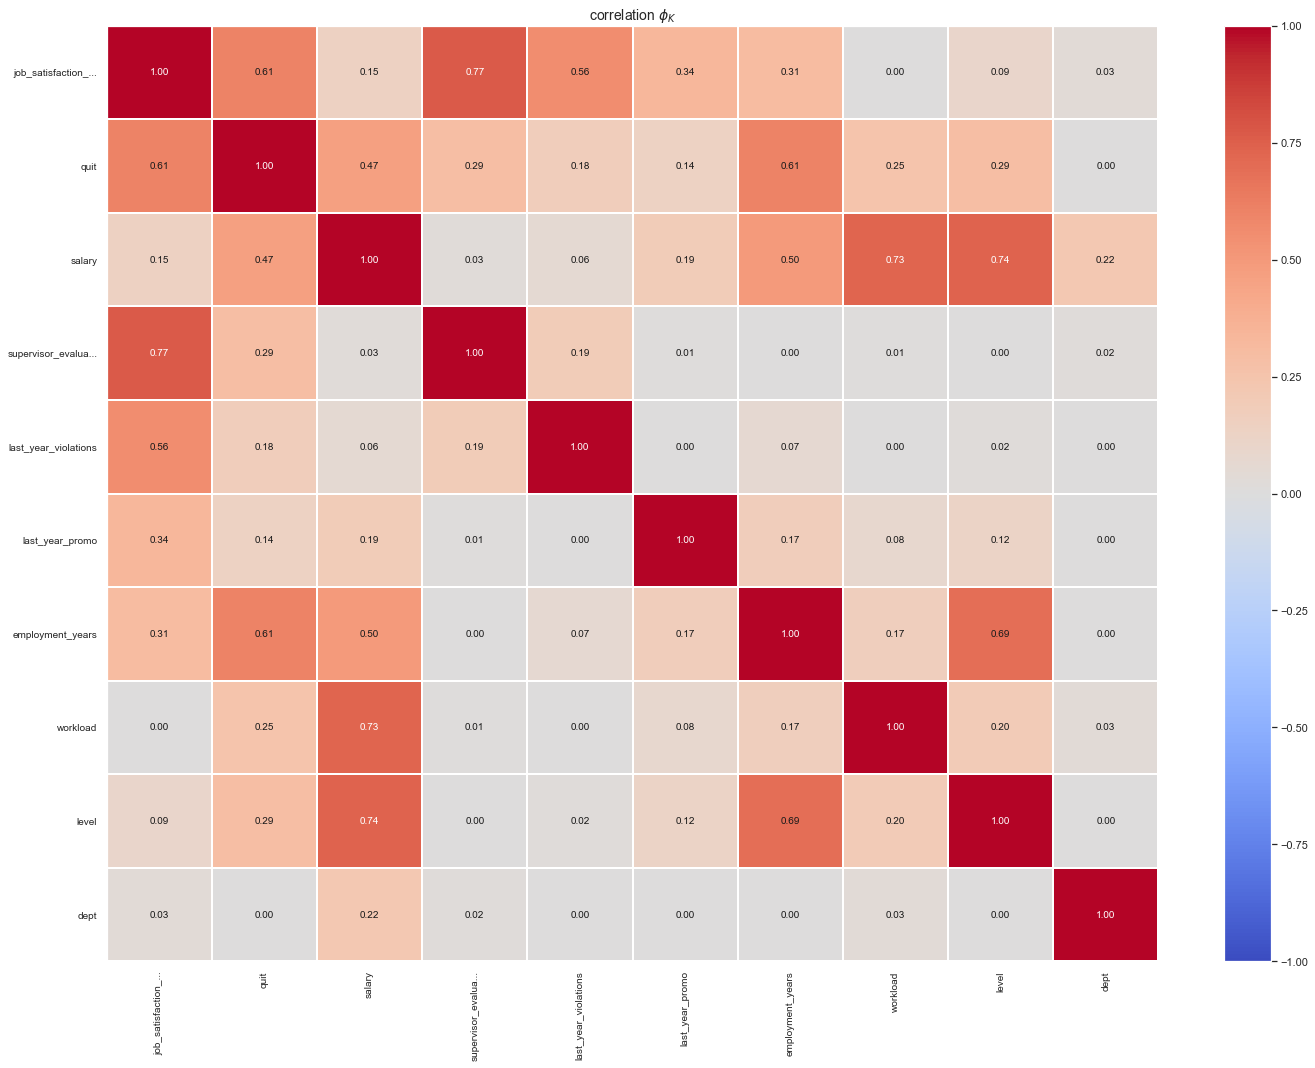

In [112]:
interval_cols = ['job_satisfaction_rate', 'salary']

phik_overview = test_q_df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Так эе как и в первом датафрейме, почти все значения корреляции возрасли, но о мультиколлениарности говорить не приходится.

### Вывод по корреляционному анализу

Матрицы корреляции показали, что мультиколлениарность в данных отсутствует.

## Подготовка данных

На этом этапе необходимо создать пайплайн, который будет подготавливать данные для работы с моделью.
Для начала преведем целевой признак в числовой формат, для того чтобы все метрики работали корректно.

In [122]:
le = LabelEncoder()
train_q_df['quit'] = le.fit_transform(train_q_df['quit'])
test_q_df['quit'] = le.transform(test_q_df['quit'])

test_q_df.head(10)

dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
429973  purchasing  middle   medium                 6              no   
850699  technology  junior   medium                 3              no   
500791       sales  middle     high                 9              no   
767867   marketing  middle     high                 3              no   
937235       sales  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  quit  \
id                                                                 
485046                   no                      5   28800     0   
686555                   no                      4   30000     0   
467458                   no                      4   19200     0   
418655                   no                      4   19200     0   
789145                   no                      5   40800     0   
429973                   no                      3   42000     0   
850699                   no                      3   26400     1   
500791                   no                      4   49200     0   
767867                  yes                      4   62400     0   
937235                  yes                      3   26400     1   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75  
429973                   0.67  
850699                   0.36  
500791                   0.73  
767867                   0.44  
937235                   0.22

Теперь разделим данные на тестовые и тренировочные выборки.

In [114]:
X_train = train_q_df.drop(['quit'], axis=1)
y_train = train_q_df['quit']
X_test = test_q_df.drop(['quit'], axis=1)
y_test = test_q_df['quit']

Теперь разделим входные параметры по категориям для дальнейшего использования масштабирования и энкодинга.

In [115]:
cols_ohe = ['dept', 'last_year_promo', 'last_year_violations']
cols_ord = ['level', 'workload']
cols_num = ['employment_years', 'salary', 'job_satisfaction_rate']

Теперь самая главная часть, создадим пайплайн, который бцдет преобразововать данные в удобоваримый формат для модели и тут же создадим итоговый пайплайн в котором сразу инициализируем модель, но пока что она ничего делать не будет.

In [116]:
ohe_pipe = Pipeline(
    [
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)


oe_pipe = Pipeline(
    [
        (
            'simple_imputer_before_oe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'oe',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simple_imputer_after_oe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

preprocessing_pipe = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cols_ohe),
        ('oe', oe_pipe, cols_ord),
        ('num', MinMaxScaler(), cols_num)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('preprocessor', preprocessing_pipe),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


### Вывод по подготовке данных

Был создан пайплайн, который полностью подготовит наши данные к использованию модели. В пайплайне используются такие методы, как: OrdinalEncoder, OneHotEncoder, MinMaxScaler. Так же на этапе подбора модели будет испольоваться StandardScaler. Так же данные были разбиты на тренировочные и тестовые выборки.

## Создание модели

Будем использовать три модели DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression. В переборе параметров так же подберем самый лучший скейлер для числовых столбцов. Для подбора будем использовать RandomizedSearchCV, со значением кросс-валидации равной 5. В качестве метрики будеи использовать метрику качества ROC-AUC.

In [117]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'models__max_depth': (None, *range(2, 11)),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_jobs = -1,
    scoring = 'roc_auc',
    random_state=42
)

rs.fit(X_train, y_train)
roc_auc = rs.best_score_
print(f'Лучшая модель и ее параметры: \n{rs.best_estimator_}')

print(f'Лучшая метрика ROC-AUC на кросс-валидации выборке: {round(roc_auc, 2)}')

Лучшая модель и ее параметры: 
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('oe',
                             

Лучшая метрика ROC-AUC тестовой выборки 0.9177


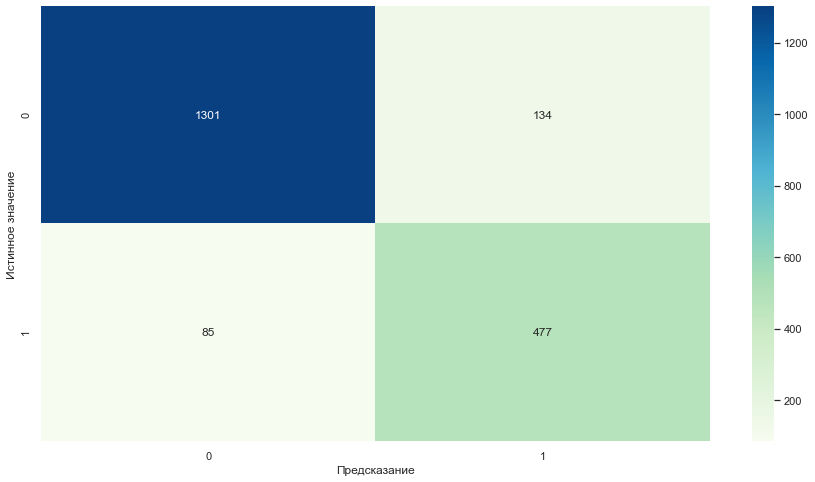

In [118]:
prediction = rs.predict_proba(X_test)[:, 1]
print(f'Лучшая метрика ROC-AUC тестовой выборки {round(roc_auc_score(y_test, prediction), 4)}')
cm = confusion_matrix(y_test, rs.predict(X_test))
sns.set()
plt.figure(figsize=(15,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказание');

Лучшей моделью для оказалась модель DecisionTreeClassifier с гиперпараметрами:

- max_depth=5
- min_samples_leaf=6
- min_samples_split=9

Ее метрика ROC-AUC на тренировочной выборке равна 0.9, а на тренировочной выбоке 0.91, по условию задачи подходящей моделью считается моель с метрикой ROC-AUC больше или равной 0.91 на тестовой выборке.

По матрице корреляции можно сказать, что модель одинаково хорошо предсказывает как увольнение сотрудников, так и то, что они останутся на работе в компании. Ошибки первого и второго рода совершены в примерно одинаковых количиствах, но без них никуда.


PermutationExplainer explainer: 2588it [03:10, 12.91it/s]                                                              


(2587, 12)

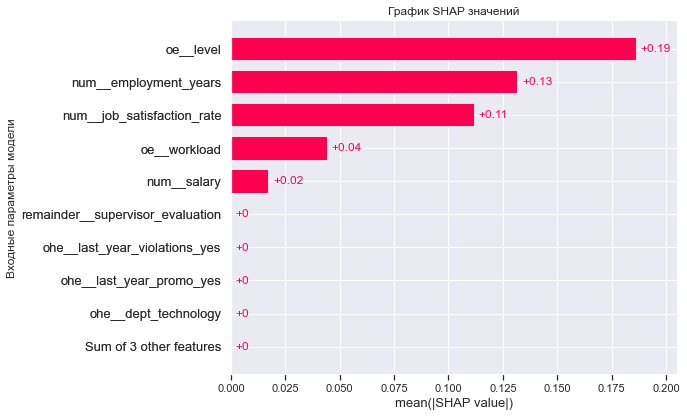

In [124]:
warnings.filterwarnings('ignore')

X = rs.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = rs.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(rs.best_estimator_['models'].predict, X)
shap_values = explainer(X)
display(shap_values.values.shape)
shap.plots.bar(shap_values, show=False)
plt.title('График SHAP значений')
plt.ylabel('Входные параметры модели')
plt.show()

Сильнее всего на увольнение сотрудника влияет его должность(джуниор, мидл, сеньер). Чуть меньше влияет стаж работы в компании и еще чуть меньше влияет уровень удовлетворенности, который мы изучали в предыдущей задаче.
Остальные признаки влияют на работу модели очень слабо, или не имеют никакого влияния на работу модели.

In [120]:
test_q_df['quit'] = rs.best_estimator_.predict(X_test)
test_q_df.head(10)

dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
429973  purchasing  middle   medium                 6              no   
850699  technology  junior   medium                 3              no   
500791       sales  middle     high                 9              no   
767867   marketing  middle     high                 3              no   
937235       sales  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  quit  \
id                                                                 
485046                   no                      5   28800     0   
686555                   no                      4   30000     0   
467458                   no                      4   19200     0   
418655                   no                      4   19200     0   
789145                   no                      5   40800     0   
429973                   no                      3   42000     0   
850699                   no                      3   26400     1   
500791                   no                      4   49200     0   
767867                  yes                      4   62400     0   
937235                  yes                      3   26400     1   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75  
429973                   0.67  
850699                   0.36  
500791                   0.73  
767867                   0.44  
937235                   0.22

# Вывод по задаче 2

В данной задаче был проделан большой объем работы для подготовки данных, для их последующей роботы с моделью. При помощи RabdomizedSearchCV была подобрана модль с лучшей метрикой ROC-AUC ей оказалась модель DecisionTreeClassifier с гиперпараметрами:
- max_depth=5
- min_samples_leaf=6
- min_samples_split=9


Ее результат на тестовой выборке равен 0.9 на тестовой выборке и 0.91 на тренировочной - это говорит о высоком качестве модели и о том, что она достаточно точно предсказывает значения уволнения работника.

Так же подбирались скейлеры и энкодеры. Так же производился выбор между двумя другими моделями (KNeighborsClassifier, LogisticRegression), но судя по результатам подбора они показали себя хуже. Это скорее всего вызвано тем, что данные не имеют сильной линейной связи с целевым признаком - это было видно еще на моменте исследовательского анализа. Скорее всего результат (коэффициент удовлетворенности сотрудников работой) складывается из общего портрета работника, поэтому лучше оказалась модель DecisionTreeClssifier с методом рабоы основанным на подборе условий из которых модель делает вывод о результате.

# Общий выыод

## Задача 1

1. **Предобработка данных**
    - id был сдеалн индексом
    - Былм удалены явные дубликаты
    - Изучены распределения всех параметров
    - Удалены все аномальные значения
2. **Исследовательский анализ**
    - Были изучены распределения всех параметров в разрезе целевого признака
    - В train_df самое большое влияние на целевой признак имеют параметры last_year_violations и last_year_promo
    - От остальных признаков целевой не имеет особо сильной зависимости. Зависимость прослеживается между уровенм сотрудника, его нагруженностью и его зарплатой
    - В тестовом датафрейме явно виден общий рост удовлетворенности сотрудников
    - Столбцы с самым сильным влиянием остались теми же, что и в предыдущем датафрейме
    - Зарплаты сотрудников немного возрасли
    - Зависимость между зарплатой сотрудников и их удовлетворенностью стала чуть более явной
3. **Корреляционный анализ**
    - Была изучена корреляция между каждым из параметров датафреймов
    - Мультиколлениарность в данных отсутсвует
4. **Подготовка данных и создание модели**
    - Был создан пайплайн, который полностью подгатавливает данные к использованию модели. В пайплайне используются такие методы, как: OrdinalEncoder, OneHotEncoder, MinMaxScaler. Так же на этапе подбора модели будет испольоваться StandardScaler.
    - Была подобрана модль с лучшей метрикой SMAPE  ей оказалась модель DecisionTreeRegressor с гиперпараметрами:
        - criterion='poisson'
        - max_depth=22
        - max_features=15
        - min_samples_leaf=3
        - min_samples_split=10

    - Результат модели на тестовой выборке равен 15.44% на тестовой выборке и 13.62% на тренировочной (это говорит о том что среднее абсолютное отклонение предсказанного занчения от истинного составляется n-ое количиство процентов).
    - Так же подбиралист скейлеры и энеодеры
5. **Советы для бизнеса**
    - По этой модели трудно дать много советов, но пару основынх можно вывести:
        - Нужно проверить насколько справедливо начальство оценивает работу сотрудников, так как этот параметр сильнее всего влияет на коэффициент удовлетворенности сотрудников
        - Так же нужно более пристально слидить за тем, что не нравится работникам, которые работают в компании не так давно или имеют должность junior, так как их уровень удовлетворенности в среднем меньше, чем у всех остальных работников
        - Так же, если это возможно постараться повысить зарплаты, так как она сильно влияет на уровень удовлетворенности сотрудников

## Задача 2
1. **Предобработка данных**
    - Тренировочный датафрейм был очищен от полных дубликатов, на этом этапе мы потеряли 35% данных - это много
    - Были изучены распределения параметров тренировочного датафрейма и датафрейма с целевым признаком, аномальных значений не обнаруженно
    - Более подробное описание распределенений можно посмотреть на этапе предобработке в пункте с интересующим названием датафрейма
2. **Исследовательский анализ данных**
    - Была рассмотрена взаимосвязь всех параметров с целевым признаком
    - В train_df самое большое влияние на целевой признак имеют параметры level, workload, last_year_promo и employment_years. От остальных признаков целевой признак тоже зависит, но не так явно как от этих входных параметров
    - Столбцы с самым сильным влиянием  в тестовом датафрейме остались теми же, что и в тренировочном
    - Действительно чем больше удовлетворенность сотрудника тем меньше шанс, что он уволится 
3. **Портрет уволившегося сотрудника**
    - С большей вероятностью уволившийся работник принадлежал отделу продаж или же отделу технологий, но стоит напомнить, что этот параметр не так сильно влияет на вероятность увольнения
    - Скорее всего этот сотрудник имед должность junior
    - Вероятнее всего уволившийся сотрудник будет иметь низукую загруженность
    - Скорее всего уволившийся сотрудник проработал в компании менее трех-четырех лет
    - Почти стопроцентно уволившийся сотрудник не получил никакого повышения за предыдущий год
    - Если работник нарушал трудовой договор, то шанс того, что он уйдет с работы возрастает в разы
    - Сотрудник, работу которого начальник оценивает на два и менее балла более склонен к увольнению
    - В основном чем меньше зарплата у пользователя, тем больше шанс, что он уйдет с работы
    - Скорее всего у сотрудника будет маленький уровень удовлетворенности работой
4. **Корреляционный анализ**
    - Была изучена кореляция между всеми параметрами
    - Мультикоррелиальность в данных отсутствует
5. **Подготовка данных и создание модели**
    - Был создан пайплайн, который полностью подготовит наши данные к использованию модели. В пайплайне используются такие методы, как: OrdinalEncoder, OneHotEncoder, MinMaxScaler. Так же на этапе подбора модели будет испольоваться StandardScaler. Так же данные были разбиты на тренировочные и тестовые выборки.
    - При помощи RabdomizedSearchCV была подобрана модль с лучшей метрикой ROC-AUC ей оказалась модель DecisionTreeClassifier с гиперпараметрами:
        - max_depth=5
        - min_samples_leaf=6
        - min_samples_split=9

    - Результат на тестовой выборке равен 0.9 на тестовой выборке и 0.91 на тренировочной - это говорит о высоком качестве модели и о том, что она достаточно точно предсказывает значения уволнения работника.
    - Так же подбирались скейлеры и энкодеры. 
    - Так же производился выбор между двумя другими моделями (KNeighborsClassifier, LogisticRegression), но судя по результатам подбора они показали себя хуже. 

6. **Соведты для бизнеса**
    - Нужно более внимательно следить за сотрудниками, которые имеют должность junior потому что они более склонны к увольнению
    - Так же нужно более внимательно следить за сотрудниками, которые не так долго работают в компании, потому  что они тоже более склонны к увольнению
    - Не стоит предвзято относиться к уровню удовлетворенности сотрудника, так как он действительно связан с увольненим сотрудника. Стоит обратить внимание на сотрудников с маленьким уровнем удовлетворенности.